# FDS Challenge

This notebook will guide you through the first steps of the competition. Our goal here is to show you how to:

1.  Load the `train.jsonl` and `test.jsonl` files from the competition data.
2.  Create a very simple set of features from the data.
3.  Train a basic model.
4.  Generate a `submission.csv` file in the correct format.
5.  Submit your results.

Let's get started!

# 1. Loading and Inspecting the Data

In [ ]:
import json
import pandas as pd
import os

# --- Define the path to our data ---
COMPETITION_NAME = 'fds-pokemon-battles-prediction-2025'
DATA_PATH = os.path.join('../input', COMPETITION_NAME)
train_file_path = "/kaggle/input/fds-pokemon-battles-prediction-2025/train.jsonl"
test_file_path = "/kaggle/input/fds-pokemon-battles-prediction-2025/train.jsonl"

train_data = []
test_data  = []

# --- Load TRAIN data ---
print(f"📦 Loading data from '{train_file_path}'...")
try:
    with open(train_file_path, 'r') as f:
        for line in f:
            train_data.append(json.loads(line))
    print(f"✅ Successfully loaded {len(train_data)} battles from train.")
    
    # Show structure of first train battle
    if train_data:
        print("\n--- Structure of the first train battle: ---")
        first_battle = train_data[0]
        battle_for_display = first_battle.copy()
        battle_for_display['battle_timeline'] = first_battle.get('battle_timeline', [])[:2]
        print(json.dumps(battle_for_display, indent=4))
        if len(first_battle.get('battle_timeline', [])) > 3:
            print("    ...")
            print("    (battle_timeline has been truncated for display)")

except FileNotFoundError:
    print(f"❌ ERROR: Could not find the training file at '{train_file_path}'.")
    print("Please make sure you have added the competition data to this notebook.")


# --- Load TEST data ---
print(f"\n📦 Loading data from '{test_file_path}'...")
try:
    with open(test_file_path, 'r') as f:
        for line in f:
            test_data.append(json.loads(line))
    print(f"✅ Successfully loaded {len(test_data)} battles from test.")
    
    if test_data:
        print("\n--- Structure of the first test battle: ---")
        first_test_battle = test_data[0]
        test_display = first_test_battle.copy()
        test_display['battle_timeline'] = test_display.get('battle_timeline', [])[:2]
        print(json.dumps(test_display, indent=4))
        if len(first_test_battle.get('battle_timeline', [])) > 3:
            print("    ...")
            print("    (battle_timeline has been truncated for display)")

except FileNotFoundError:
    print(f"❌ ERROR: Could not find the test file at '{test_file_path}'.")
    print("Please make sure you have added the competition data to this notebook.")

# 2. Features Engineering

In [2]:
# =========================
# CELLA 2 — Feature Engineering 
# =========================

from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import json
from typing import List, Dict, Any, Tuple
from collections import Counter, defaultdict

# ---------------------------------------------
# Base stat keys used throughout the feature extraction
# ---------------------------------------------
BASE_STAT_KEYS = ["base_hp","base_atk","base_def","base_spa","base_spd","base_spe"]

# ---------------------------------------------
# Static team composition and stats
# ---------------------------------------------
def unique_types(team: List[Dict[str, Any]]) -> int:
    collected=[]
    for p in team or []:
        ts=p.get("types") or []
        if isinstance(ts,str): ts=[ts]
        collected.extend([t for t in ts if t])
    return len(set(collected))

def sum_stats_of_team(team: List[Dict[str, Any]]) -> float:
    total=0.0
    for p in team or []:
        for k in BASE_STAT_KEYS:
            v=p.get(k)
            if isinstance(v,(int,float)):
                total+=float(v)
    return total

def avg_stats_of_team(team: List[Dict[str, Any]]) -> float:
    if not team:
        return 0.0
    per=[]
    for p in team:
        vals=[p.get(k) for k in BASE_STAT_KEYS if isinstance(p.get(k),(int,float))]
        if vals:
            per.append(sum(vals)/len(vals))
    return float(sum(per)/len(per)) if per else 0.0

def sum_and_avg_of_single(poke: dict) -> Tuple[float, float]:
    vals = [poke.get(k) for k in BASE_STAT_KEYS if isinstance(poke.get(k), (int, float))]
    if not vals:
        return 0.0, 0.0
    total = float(sum(vals))
    return total, total / len(vals)

def team_stat_variance(team: List[Dict[str,Any]]) -> float:
    if not team:
        return 0.0
    per=[]
    for p in team:
        vals=[p.get(k) for k in BASE_STAT_KEYS if isinstance(p.get(k),(int,float))]
        if vals:
            per.append(sum(vals)/len(vals))
    if len(per)<2:
        return 0.0
    return float(pd.Series(per).var())

def _team_speed_stats(team):
    """Return mean and max base speed over a team."""
    sp = [p.get("base_spe", 0.0) for p in team or [] if isinstance(p.get("base_spe", None), (int, float))]
    if not sp:
        return 0.0, 0.0
    return float(np.mean(sp)), float(np.max(sp))

# ---------------------------------------------
# General numeric helpers
# ---------------------------------------------
def _safe_mean(arr): 
    return float(np.mean(arr)) if arr else 0.0

def _safe_ratio(a,b,cap=10.0):
    r=a/(b+1e-6)
    if r < 0: r = 0.0
    if r > cap: r = cap
    if not np.isfinite(r): r = 0.0
    return float(r)

# ---------------------------------------------
# Timeline-based HP feature extraction
# ---------------------------------------------
def get_timeline(r: Dict[str,Any], max_turns: int = 30):
    tl = r.get("battle_timeline",[]) or []
    return tl[:max_turns] if isinstance(tl,list) else []

def _extract_hp_series(tl):
    p1=[]; p2=[]
    for t in tl:
        if not isinstance(t,dict): 
            continue
        s1=t.get("p1_pokemon_state") or {}
        s2=t.get("p2_pokemon_state") or {}
        v1=s1.get("hp_pct"); v2=s2.get("hp_pct")
        if isinstance(v1,(int,float)) and isinstance(v2,(int,float)):
            p1.append(float(v1)); p2.append(float(v2))
    return p1,p2

def _mean_last_std_min(arr):
    if not arr:
        return 0.0,0.0,0.0,0.0
    x=np.array(arr,dtype=float)
    return float(x.mean()), float(x[-1]), float(x.std(ddof=0)), float(x.min())

def _window(arr,n): return arr[:n] if arr else []
def _frac_positive(arr): return float((np.array(arr)>0).mean()) if arr else 0.0
def _slope(arr):
    if len(arr)<2: return 0.0
    x=np.arange(len(arr))
    m,_=np.polyfit(x,np.array(arr),1)
    return float(m)
def _auc_pct(arr): return float(np.sum(arr)/(100.0*len(arr))) if arr else 0.0
def _status_count(tl,who):
    cnt=0
    k=f"{who}_pokemon_state"
    for t in tl:
        if not isinstance(t,dict): continue
        st=(t.get(k) or {}).get("status",None)
        if st not in (None,"","none","NONE"):
            cnt+=1
    return float(cnt)
def _ko_count(arr): return float(sum(1 for v in arr if v==0))

# ---------------------------------------------
# Move-related statistics from timeline
# ---------------------------------------------
def _move_stats_for_side(tl, who, window=None):
    key=f"{who}_move_details"
    seq = tl if window is None else tl[:window]
    pw, ac, pr = [], [], []
    for t in seq:
        md=t.get(key) or {}
        bp=md.get("base_power"); acc=md.get("accuracy"); pri=md.get("priority")
        if isinstance(bp,(int,float)): pw.append(float(bp))
        if isinstance(acc,(int,float)): ac.append(float(acc))
        if isinstance(pri,(int,float)): pr.append(float(pri))
    suf="" if window is None else f"_{window}"
    return {
        f"mv_{who}_power_mean{suf}": _safe_mean(pw),
        f"mv_{who}_acc_mean{suf}":   _safe_mean(ac),
        f"mv_{who}_priority_mean{suf}": _safe_mean(pr),
    }
# ---------------------------------------------
# Type effectiveness helpers (uppercase canonical)
# ---------------------------------------------
_TYPE_CHART = {
    "NORMAL":   {"ROCK":0.5, "GHOST":0.0, "STEEL":0.5},
    "FIRE":     {"FIRE":0.5, "WATER":0.5, "GRASS":2.0, "ICE":2.0, "BUG":2.0, "ROCK":0.5, "DRAGON":0.5, "STEEL":2.0},
    "WATER":    {"FIRE":2.0, "WATER":0.5, "GRASS":0.5, "GROUND":2.0, "ROCK":2.0, "DRAGON":0.5},
    "ELECTRIC": {"WATER":2.0, "ELECTRIC":0.5, "GRASS":0.5, "GROUND":0.0, "FLYING":2.0, "DRAGON":0.5},
    "GRASS":    {"FIRE":0.5, "WATER":2.0, "GRASS":0.5, "POISON":0.5, "GROUND":2.0, "FLYING":0.5, "BUG":0.5, "ROCK":2.0, "DRAGON":0.5, "STEEL":0.5},
    "ICE":      {"FIRE":0.5, "WATER":0.5, "GRASS":2.0, "GROUND":2.0, "FLYING":2.0, "DRAGON":2.0, "STEEL":0.5},
    "FIGHTING": {"NORMAL":2.0, "ICE":2.0, "POISON":0.5, "FLYING":0.5, "PSYCHIC":0.5, "BUG":0.5, "ROCK":2.0, "GHOST":0.0, "DARK":2.0, "STEEL":2.0, "FAIRY":0.5},
    "POISON":   {"GRASS":2.0, "POISON":0.5, "GROUND":0.5, "ROCK":0.5, "GHOST":0.5, "STEEL":0.0, "FAIRY":2.0},
    "GROUND":   {"FIRE":2.0, "ELECTRIC":2.0, "GRASS":0.5, "POISON":2.0, "FLYING":0.0, "BUG":0.5, "ROCK":2.0, "STEEL":2.0},
    "FLYING":   {"ELECTRIC":0.5, "GRASS":2.0, "FIGHTING":2.0, "BUG":2.0, "ROCK":0.5, "STEEL":0.5},
    "PSYCHIC":  {"FIGHTING":2.0, "POISON":2.0, "PSYCHIC":0.5, "DARK":0.0, "STEEL":0.5},
    "BUG":      {"FIRE":0.5, "GRASS":2.0, "FIGHTING":0.5, "POISON":0.5, "FLYING":0.5, "PSYCHIC":2.0, "GHOST":0.5, "DARK":2.0, "STEEL":0.5, "FAIRY":0.5},
    "ROCK":     {"FIRE":2.0, "ICE":2.0, "FIGHTING":0.5, "GROUND":0.5, "FLYING":2.0, "BUG":2.0, "STEEL":0.5},
    "GHOST":    {"NORMAL":0.0, "PSYCHIC":2.0, "GHOST":2.0, "DARK":0.5},
    "DRAGON":   {"DRAGON":2.0, "STEEL":0.5, "FAIRY":0.0},
    "DARK":     {"FIGHTING":0.5, "PSYCHIC":2.0, "GHOST":2.0, "DARK":0.5, "FAIRY":0.5},
    "STEEL":    {"FIRE":0.5, "WATER":0.5, "ELECTRIC":0.5, "ICE":2.0, "ROCK":2.0, "FAIRY":2.0, "STEEL":0.5},
    "FAIRY":    {"FIRE":0.5, "FIGHTING":2.0, "POISON":0.5, "DRAGON":2.0, "DARK":2.0, "STEEL":0.5},
}

def _type_multiplier(move_type: str, target_types: List[str] | set) -> float:
    """Effectiveness multiplier for move_type against mono/dual target types."""
    if not move_type:
        return 1.0
    mt = move_type.strip().upper()
    mult = 1.0
    for tt in target_types or []:
        tt_up = str(tt).strip().upper()
        mult *= _TYPE_CHART.get(mt, {}).get(tt_up, 1.0)
    return float(mult) if np.isfinite(mult) else 1.0

def _avg_type_eff_p1_vs_p2lead(tl: list[dict], p2_lead_types: List[str] | set, window: int | None = None) -> float:
    """Mean effectiveness of P1 used moves vs P2 lead types over full/early window."""
    seq = tl if window is None else tl[:window]
    vals = []
    for t in seq:
        md = t.get("p1_move_details") or {}
        mv_t = md.get("type")
        if isinstance(mv_t, str) and p2_lead_types:
            vals.append(_type_multiplier(mv_t, p2_lead_types))
    return float(np.mean(vals)) if vals else 1.0  # neutral if unknown

# ---------------------------------------------
# STAB features (Same-Type Attack Bonus)
# ---------------------------------------------
def _name_to_types_map_p1(record: Dict[str, Any]) -> Dict[str, set]:
    mp = {}
    for p in record.get("p1_team_details", []) or []:
        nm = (p.get("name") or "").strip().lower()
        ts = p.get("types") or []
        if isinstance(ts, str):
            ts = [ts]
        ts_norm = {str(t).strip().upper() for t in ts if t and str(t).strip().upper() != "NOTYPE"}
        if nm:
            mp[nm] = ts_norm
    return mp

def _active_name_and_move_type(turn: Dict[str, Any], who: str) -> tuple[str, str]:
    state = turn.get(f"{who}_pokemon_state") or {}
    md    = turn.get(f"{who}_move_details") or {}
    nm = (state.get("name") or "").strip().lower()
    mv_t = (md.get("type") or "").strip().upper()
    return nm, mv_t

def _stab_features(record: Dict[str, Any], max_turns: int = 30) -> Dict[str, float]:
    tl = get_timeline(record, max_turns=max_turns)

    # type maps of P1 (name -> set(types))
    p1_types_map = _name_to_types_map_p1(record)

    # ratio & diff - helpers
    def _accumulate(seq):
        p1_total = p1_stab = 0
        p2_total = p2_stab = 0  

        for t in seq:
            # P1
            nm1, mv1_type = _active_name_and_move_type(t, "p1")
            if mv1_type:
                p1_total += 1
                types1 = p1_types_map.get(nm1, set())
                is_stab = (mv1_type in types1) if types1 else False
                if is_stab:
                    p1_stab += 1

        p1_ratio = (p1_stab / p1_total) if p1_total > 0 else 0.0
        p2_ratio = 0.0

        return {
            "stab_stab_ratio_diff": float(p1_ratio - p2_ratio),
            "stab_stab_ratio_ratio": _safe_ratio(p1_ratio, p2_ratio if p2_ratio > 0 else 1e-6, cap=10.0),
        }

    full = _accumulate(tl)
    w5   = _accumulate(tl[:5])

    return {
        "stab_stab_ratio_diff_full":  float(full["stab_stab_ratio_diff"]),
        "stab_stab_ratio_ratio_full": float(full["stab_stab_ratio_ratio"]),
        "stab_stab_ratio_diff_w5":    float(w5["stab_stab_ratio_diff"]),
        "stab_stab_ratio_ratio_w5":   float(w5["stab_stab_ratio_ratio"]),
    }

# ---------------------------------------------
# Early momentum (first 3 turns)
# ---------------------------------------------
def _first_ko_flag(hp_series: list[float]) -> int:
    for v in hp_series:
        if isinstance(v, (int, float)) and float(v) == 0.0:
            return 1
    return 0

def _first_status_advantage(tl: list[dict], first_n: int = 3) -> float:
    p1 = p2 = 0
    for t in tl[:first_n]:
        s1 = (t.get("p1_pokemon_state") or {}).get("status", None)
        s2 = (t.get("p2_pokemon_state") or {}).get("status", None)
        if s1 not in (None, "", "none", "NONE"): p1 += 1
        if s2 not in (None, "", "none", "NONE"): p2 += 1
    return float(p1 - p2)

def _early_momentum_features(record: Dict[str, Any], first_n: int = 3) -> Dict[str, float]:
    tl = get_timeline(record, max_turns=30)
    p1, p2 = _extract_hp_series(tl)
    p1w, p2w = _window(p1, first_n), _window(p2, first_n)

    diffw = [a - b for a, b in zip(p1w, p2w)] if p1w and p2w and len(p1w) == len(p2w) else []
    mean_diff_first = float(np.mean(diffw)) if diffw else 0.0

    p1_first_ko = _first_ko_flag(p2w)
    p2_first_ko = _first_ko_flag(p1w)
    first_ko_score = float(p1_first_ko - p2_first_ko)

    status_adv = _first_status_advantage(tl, first_n=first_n)

    return {
        f"early_hp_diff_mean_{first_n}": mean_diff_first,
        f"early_first_ko_score_{first_n}": first_ko_score,
        f"early_status_advantage_{first_n}": status_adv,
    }

# ---------------------------------------------
# Priority counts and advantage (full / 5 / 10)
# ---------------------------------------------
def _priority_counts(record: Dict[str, Any], max_turns: int = 30, window: int | None = None) -> Dict[str, float]:
    tl = get_timeline(record, max_turns=max_turns)
    turns = tl if window is None else tl[:window]

    p1_count = 0.0
    p2_count = 0.0
    for t in turns:
        md1 = t.get("p1_move_details") or {}
        md2 = t.get("p2_move_details") or {}
        pri1 = md1.get("priority")
        pri2 = md2.get("priority")
        if isinstance(pri1, (int, float)) and float(pri1) > 0: p1_count += 1.0
        if isinstance(pri2, (int, float)) and float(pri2) > 0: p2_count += 1.0

    suf = "" if window is None else f"_{window}"
    return {
        f"mv_p1_priority_count{suf}": p1_count,
        f"mv_p2_priority_count{suf}": p2_count,
        f"mv_priority_count_diff{suf}": p1_count - p2_count,
    }

def _priority_feature_block(record: Dict[str, Any]) -> Dict[str, float]:
    f = {}
    f.update(_priority_counts(record, max_turns=30, window=None))
    f.update(_priority_counts(record, max_turns=30, window=5))
    return f


# ====================================
# LEAD MATCHUP / DAMAGE-INDEX HELPERS
# ====================================
def _simple_damage_index(base_power: float, stab: bool, eff: float, atk_proxy: float, def_proxy: float) -> float:
    if not isinstance(base_power, (int, float)) or base_power <= 0:
        return 0.0
    s = 1.5 if stab else 1.0
    ratio = (float(atk_proxy) + 1e-3) / (float(def_proxy) + 1e-3)
    val = float(base_power) * s * float(eff) * ratio
    return float(val) if np.isfinite(val) else 0.0

def _p1_vs_p2lead_matchup_index(record: dict, tl: list[dict]) -> dict:
    p1_team = record.get("p1_team_details", []) or []
    p1_mean_atk = float(np.mean([p.get("base_atk", 0) for p in p1_team])) if p1_team else 0.0
    p1_mean_spa = float(np.mean([p.get("base_spa", 0) for p in p1_team])) if p1_team else 0.0

    lead = record.get("p2_lead_details") or {}
    p2_types = lead.get("types") or []
    if isinstance(p2_types, str): p2_types = [p2_types]
    p2_types = [t for t in p2_types if t]
    p2_def = float(lead.get("base_def", 0.0) or 0.0)
    p2_spd = float(lead.get("base_spd", 0.0) or 0.0)

    p1map = {}
    for p in p1_team:
        nm = (p.get("name") or "").strip().lower()
        ts = p.get("types") or []
        if isinstance(ts, str): ts = [ts]
        p1map[nm] = {str(x).strip().upper() for x in ts if x}

    def _acc(window=None):
        seq = tl if window is None else tl[:window]
        vals = []
        for t in seq:
            md = t.get("p1_move_details") or {}
            bp = md.get("base_power"); cat = md.get("category"); mtype = md.get("type")
            if not isinstance(bp, (int, float)) or bp <= 0: 
                continue
            nm = (t.get("p1_pokemon_state") or {}).get("name", "")
            nm = (nm or "").strip().lower()
            is_stab = str(mtype or "").strip().upper() in p1map.get(nm, set())
            eff = _type_multiplier(mtype, p2_types)
            if (cat or "").upper() == "PHYSICAL":
                idx = _simple_damage_index(bp, is_stab, eff, p1_mean_atk, p2_def)
            elif (cat or "").upper() == "SPECIAL":
                idx = _simple_damage_index(bp, is_stab, eff, p1_mean_spa, p2_spd)
            else:
                idx = 0.0
            vals.append(idx)
        return float(np.mean(vals)) if vals else 0.0

    return {
        "lead_matchup_p1_index_full": _acc(None),
        "lead_matchup_p1_index_5":    _acc(5),
    }

# ==========================
# SWITCH / HAZARD / MOMENTUM
# ==========================
def _switch_count(tl: list[dict], who: str) -> float:
    last = None
    cnt = 0
    key = f"{who}_pokemon_state"
    for t in tl:
        nm = (t.get(key) or {}).get("name")
        if nm is None:
            continue
        if last is not None and nm != last:
            cnt += 1
        last = nm
    return float(cnt)

HAZARD_MOVES = {"stealthrock", "spikes", "toxicspikes", "stickyweb"}

def _hazard_flags(tl: list[dict]) -> dict:
    p1 = p2 = 0.0
    for t in tl:
        m1 = (t.get("p1_move_details") or {}).get("name")
        m2 = (t.get("p2_move_details") or {}).get("name")
        if m1 and str(m1).strip().lower() in HAZARD_MOVES: p1 = 1.0
        if m2 and str(m2).strip().lower() in HAZARD_MOVES: p2 = 1.0
    return {"hazard_p1_flag": p1, "hazard_p2_flag": p2, "hazard_flag_diff": p1 - p2}

def _momentum_shift(tl: list[dict], t1: int = 3, t2: int = 10) -> dict:
    def _hp_diff_mean(win):
        p1, p2 = _extract_hp_series(win)
        if not p1 or not p2 or len(p1) != len(p2): return 0.0
        d = [a-b for a,b in zip(p1,p2)]
        return float(np.mean(d)) if d else 0.0
    d1 = _hp_diff_mean(tl[:t1]); d2 = _hp_diff_mean(tl[:t2])
    return {"momentum_shift_3_10": float(d1 - d2), "momentum_shift_abs_3_10": float(abs(d1 - d2))}

HEAL_MOVES = {"recover","roost","softboiled","rest","wish","synthesis","morningsun","moonlight","drainpunch","leechseed"}

def _recovery_pressure(tl: list[dict]) -> dict:
    p1 = p2 = 0.0
    for t in tl:
        m1 = (t.get("p1_move_details") or {}).get("name")
        m2 = (t.get("p2_move_details") or {}).get("name")
        if m1 and str(m1).strip().lower() in HEAL_MOVES: p1 += 1.0
        if m2 and str(m2).strip().lower() in HEAL_MOVES: p2 += 1.0
    return {"recover_p1_count": p1, "recover_p2_count": p2, "recover_count_diff": p1 - p2}

# ---------------------------------------------
# NEW FEATURES 
# ---------------------------------------------
def new_features(r):
    tl = get_timeline(r, max_turns=30)
    p1, p2 = _extract_hp_series(tl)
    t1 = r.get("p1_team_details", []) or []
    lead = r.get("p2_lead_details", {}) or {}

    f = {}
    if len(p1) >= 3 and len(p2) >= 3:
        f['early_hp_winner'] = 1.0 if np.mean(p1[:3]) > np.mean(p2[:3]) else 0.0
        f['early_hp_difference'] = np.mean(p1[:3]) - np.mean(p2[:3])

    if p1 and p2:
        f['final_hp_winner'] = 1.0 if p1[-1] > p2[-1] else 0.0
        f['final_hp_difference'] = p1[-1] - p2[-1]

    p1_total_stats = sum(p.get(k, 0) for p in t1 for k in BASE_STAT_KEYS)
    p2_total_stats = sum(lead.get(k, 0) for k in BASE_STAT_KEYS)
    f['stronger_team'] = 1.0 if p1_total_stats > p2_total_stats else 0.0
    f['team_strength_gap'] = p1_total_stats - p2_total_stats

    p1_speeds = [p.get('base_spe', 0) for p in t1]
    p2_speed = lead.get('base_spe', 0)
    f['faster_team'] = 1.0 if max(p1_speeds, default=0) > p2_speed else 0.0
    f['speed_advantage'] = max(p1_speeds, default=0) - p2_speed
    f['num_faster_pokemon'] = sum(1 for s in p1_speeds if s > p2_speed)

    f['p1_danger_count'] = sum(1 for hp in p1 if 0 < hp < 25)
    f['p2_danger_count'] = sum(1 for hp in p2 if 0 < hp < 25)
    f['survived_more_danger'] = 1.0 if f['p1_danger_count'] < f['p2_danger_count'] else 0.0
    return f

# ---------------------------------------------
# Mirko & Deb
# ---------------------------------------------
def get_defensive_profile(types):
    """
    Combined defensive multipliers for a defender with 'types' against every attack type.
    Fixed: use attacking type first, then multiply by defender types.
    """
    types = types or []
    if isinstance(types, str): types = [types]
    types_up = [str(t).strip().upper() for t in types if t]

    combined = {}
    for atk_type in _TYPE_CHART.keys():
        mult = 1.0
        for tdef in types_up:
            mult *= _TYPE_CHART.get(atk_type, {}).get(tdef, 1.0)
        combined[atk_type] = float(mult)
    return combined

def new_features_mirko(battle):
    features = {}
    # Player 1 Team aggregate
    p1_team = battle.get('p1_team_details', []) or []
    if p1_team:
        ratios = []
        v_hp=[]; v_spe=[]; v_atk=[]; v_def=[]
        all_types=[]
        weaknesses=[]; resistances=[]; immunities=[]
        for p in p1_team:
            if not isinstance(p, dict): 
                continue
            off = (p.get("base_atk",0) + p.get("base_spa",0))
            deff = (p.get("base_def",0) + p.get("base_spd",0))
            ratios.append(off / deff if deff > 0 else 0.0)

            v_hp.append(p.get('base_hp',0)); v_spe.append(p.get('base_spe',0))
            v_atk.append(p.get('base_atk',0)); v_def.append(p.get('base_def',0))

            ts = p.get("types") or []
            if isinstance(ts,str): ts=[ts]
            all_types.extend([t for t in ts if str(t).lower()!='notype'])

            prof = get_defensive_profile(ts)
            w = sum(1 for m in prof.values() if m > 1)
            r = sum(1 for m in prof.values() if 0 < m < 1)
            i = sum(1 for m in prof.values() if m == 0)
            weaknesses.append(w); resistances.append(r); immunities.append(i)

        features["avg_type_role_ratio"] = float(np.mean(ratios)) if ratios else 0.0
        features['p1_var_hp']  = float(np.std(v_hp)) if v_hp else 0.0
        features['p1_var_spe'] = float(np.std(v_spe)) if v_spe else 0.0
        features['p1_var_atk'] = float(np.std(v_atk)) if v_atk else 0.0
        features['p1_var_def'] = float(np.std(v_def)) if v_def else 0.0

        unique_types = len(set(all_types))
        features['diversity_ratio'] = unique_types / 6.0

        features["avg_weaknesses"] = float(np.mean(weaknesses))  if weaknesses  else 0.0
        features["avg_resistances"] = float(np.mean(resistances)) if resistances else 0.0
        features["avg_immunities"] = float(np.mean(immunities))  if immunities  else 0.0

    # P2 lead raw stats
    p2_lead = battle.get('p2_lead_details') or {}
    if isinstance(p2_lead, dict) and p2_lead:
        features['p2_lead_hp']  = p2_lead.get('base_hp', 0)
        features['p2_lead_spe'] = p2_lead.get('base_spe', 0)
        features['p2_lead_atk'] = p2_lead.get('base_atk', 0)
        features['p2_lead_def'] = p2_lead.get('base_def', 0)

    # Voluntary leave counters (None move_details ~ skipped)
    tl = battle.get('battle_timeline', []) or []
    idx_none_p2 = [i+1 for i,e in enumerate(tl) if e.get('p2_move_details') is None]
    idx_none_p1 = [i+1 for i,e in enumerate(tl) if e.get('p1_move_details') is None]
    def _bucket_count(idxs,a,b): return len([x for x in idxs if a<=x<=b])
    features['vol_leave_diff_1'] = _bucket_count(idx_none_p1,1,10)  - _bucket_count(idx_none_p2,1,10)
    features['vol_leave_diff_2'] = _bucket_count(idx_none_p1,11,20) - _bucket_count(idx_none_p2,11,20)
    features['vol_leave_diff_3'] = _bucket_count(idx_none_p1,21,10**9) - _bucket_count(idx_none_p2,21,10**9)

    # Forced leave heuristics (name change + action executed)
    def _forced_counts(side_key, move_key):
        lst=[]
        for t in tl:
            lst.append([ (t.get(side_key) or {}).get("name"), (t.get(move_key) is None) ])
        c1=c2=c3=0
        for i in range(len(lst)-1):
            changed = (lst[i+1][0] != lst[i][0])
            acted   = (lst[i+1][1] == False)
            turn_idx = i+1
            if changed and acted:
                if 1<=turn_idx<=10: c1+=1
                elif 11<=turn_idx<=20: c2+=1
                else: c3+=1
        return c1,c2,c3
    p1c1,p1c2,p1c3 = _forced_counts("p1_pokemon_state","p1_move_details")
    p2c1,p2c2,p2c3 = _forced_counts("p2_pokemon_state","p2_move_details")
    features['forced_leave_diff_1'] = float(p1c1 - p2c1)
    features['forced_leave_diff_2'] = float(p1c2 - p2c2)
    features['forced_leave_diff_3'] = float(p1c3 - p2c3)

    # IDs / target
    features['battle_id'] = battle.get('battle_id')
    if 'player_won' in battle: features['player_won'] = int(battle['player_won'])
    return features

# ======= helpers for team & HP & damage stats =======
def _pnames_from_p1_team(record):
    team = record.get("p1_team_details", []) or []
    names = []
    for p in team:
        if isinstance(p, dict):
            nm = (p.get("name") or "").strip().lower()
            if nm: names.append(nm)
    return names

def _pname_from_p2_lead(record):
    lead = record.get("p2_lead_details") or {}
    if isinstance(lead, dict):
        nm = (lead.get("name") or "").strip().lower()
        return nm if nm else None
    return None

def build_pokemon_win_stats(train_data, alpha=1.0):
    games = defaultdict(int); wins = defaultdict(int)
    for r in train_data:
        p1_names = _pnames_from_p1_team(r)
        p2_lead  = _pname_from_p2_lead(r)
        p1_won   = bool(r.get("player_won", False))
        for nm in p1_names: games[nm]+=1
        if p2_lead: games[p2_lead]+=1
        if p1_won:
            for nm in p1_names: wins[nm]+=1
        else:
            if p2_lead: wins[p2_lead]+=1
    winrate={}
    for nm in games:
        g=games[nm]; w=wins[nm]
        wr=(w+alpha)/(g+2*alpha)
        winrate[nm]={"games":g,"wins":w,"winrate":wr}
    return winrate

def team_score_from_stats(team_names, stats, default_wr=0.5):
    vals=[stats.get((nm or "").strip().lower(),{}).get("winrate",default_wr) for nm in team_names if nm]
    return float(np.mean(vals)) if vals else default_wr

def predict_from_stats(test_record, stats, threshold=0.5):
    p1_names = _pnames_from_p1_team(test_record)
    score = team_score_from_stats(p1_names, stats, default_wr=0.5)
    return (score > threshold), score

def build_pokemon_hp_stats(train_data):
    hp_sum=defaultdict(float); hp_count=defaultdict(int)
    for r in train_data:
        timeline = r.get("battle_timeline", []) or []
        if not timeline: continue
        last_turn = timeline[-1]
        for player_key in ["p1_pokemon_state", "p2_pokemon_state"]:
            name = (last_turn.get(player_key, {}).get("name") or "").strip().lower()
            hp   = last_turn.get(player_key, {}).get("hp_pct", None)
            if name and isinstance(hp,(int,float)):
                hp_sum[name]+=float(hp); hp_count[name]+=1
    stats = {name: {"count": hp_count[name], "hp_mean": hp_sum[name]/hp_count[name]} for name in hp_sum}
    return stats

def team_hp_score(team_names, hp_stats, default_hp=50.0):
    vals=[]
    for name in team_names:
        n=(name or "").strip().lower()
        vals.append(hp_stats.get(n,{}).get("hp_mean", default_hp))
    return float(np.mean(vals)) if vals else default_hp

def build_pokemon_avg_damage(train_data):
    total_damage=defaultdict(float); battles_count=defaultdict(int)
    for battle in train_data:
        timeline = battle.get("battle_timeline", []) or []
        p1_names = [(p.get("name") or "").lower() for p in (battle.get("p1_team_details", []) or []) if isinstance(p,dict)]
        p2_lead  = battle.get("p2_lead_details", {})
        p2_name  = (p2_lead.get("name") or "").lower() if isinstance(p2_lead,dict) else None

        for name in p1_names: battles_count[name]+=1
        if p2_name: battles_count[p2_name]+=1

        for i in range(1,len(timeline)):
            prev, curr = timeline[i-1], timeline[i]
            hp2b = (prev.get("p2_pokemon_state") or {}).get("hp_pct", None)
            hp2a = (curr.get("p2_pokemon_state") or {}).get("hp_pct", None)
            if isinstance(hp2b,(int,float)) and isinstance(hp2a,(int,float)):
                dmg=max(0,hp2b-hp2a)
                if p1_names and dmg>0:
                    for name in p1_names: total_damage[name]+=dmg
            hp1b = (prev.get("p1_pokemon_state") or {}).get("hp_pct", None)
            hp1a = (curr.get("p1_pokemon_state") or {}).get("hp_pct", None)
            if isinstance(hp1b,(int,float)) and isinstance(hp1a,(int,float)):
                dmg=max(0,hp1b-hp1a)
                if p2_name and dmg>0:
                    total_damage[p2_name]+=dmg
    avg_damage = {name: total_damage[name]/battles_count[name] for name in battles_count if battles_count[name]>0}
    return avg_damage

def damage_feature_for_battle(record, avg_damage):
    p1_names = [(p.get("name") or "").lower() for p in (record.get("p1_team_details",[]) or []) if isinstance(p,dict)]
    p1_damage_score = sum(avg_damage.get(name, 0.0) for name in p1_names)
    p2_lead = record.get("p2_lead_details", {}) or {}
    p2_name = (p2_lead.get("name") or "").lower() if isinstance(p2_lead,dict) else None
    p2_damage_score = avg_damage.get(p2_name,0.0) if p2_name else 0.0
    diff = p1_damage_score - p2_damage_score
    return {"avg_damage_p1": p1_damage_score, "avg_damage_p2": p2_damage_score, "avg_damage_diff": diff, "damage_prediction": 1.0 if diff>0 else 0.0}

# ======= Deb's feature block (kept) =======
def new_features_deb(r):
    tl = get_timeline(r, max_turns=30)
    p1, p2 = _extract_hp_series(tl)
    t1 = r.get("p1_team_details", []) or []
    lead = r.get("p2_lead_details", {}) or {}
    f = {}

    if len(p1) >= 3 and len(p2) >= 3:
        media_p1 = float(np.mean(p1[:3])); media_p2 = float(np.mean(p2[:3]))
        f['is_p1_higher_avg_hp_after_3_turns'] = 1.0 if media_p1 > media_p2 else 0.0
        f['avg_hp_difference_after_3_turns'] = media_p1 - media_p2

    if p1 and p2:
        f['is_player1_final_hp_winner'] = 1.0 if p1[-1] > p2[-1] else 0.0
        f['final_hp_difference'] = p1[-1] - p2[-1]

    if len(p1) >= 6 and len(p2) >= 6:
        f['comeback_happened'] = float((np.mean(p1[:3]) > np.mean(p2[:3])) != (np.mean(p1[-3:]) > np.mean(p2[-3:])))

    p1_total_stats = sum(p.get('base_hp',0)+p.get('base_atk',0)+p.get('base_def',0)+p.get('base_spa',0)+p.get('base_spd',0)+p.get('base_spe',0) for p in t1 if isinstance(p,dict))
    p2_total_stats = (lead.get('base_hp',0)+lead.get('base_atk',0)+lead.get('base_def',0)+lead.get('base_spa',0)+lead.get('base_spd',0)+lead.get('base_spe',0))
    f['stronger_team'] = 1.0 if p1_total_stats > p2_total_stats else 0.0
    f['team_strength_gap'] = p1_total_stats - p2_total_stats

    p1_speeds = [p.get('base_spe', 0) for p in t1 if isinstance(p,dict)]
    p2_speed = lead.get('base_spe', 0) if isinstance(lead,dict) else 0
    if p1_speeds:
        f['faster_team'] = 1.0 if max(p1_speeds) > p2_speed else 0.0
        f['speed_advantage'] = max(p1_speeds) - p2_speed
        f['num_faster_pokemon'] = sum(1 for s in p1_speeds if s > p2_speed)
    else:
        f['faster_team'] = 0.0; f['speed_advantage'] = 0.0; f['num_faster_pokemon'] = 0.0

    p1_powers=[]; p2_powers=[]
    for t in tl:
        if not isinstance(t,dict): continue
        md1=t.get('p1_move_details'); md2=t.get('p2_move_details')
        bp1 = md1.get('base_power') if isinstance(md1,dict) else None
        bp2 = md2.get('base_power') if isinstance(md2,dict) else None
        if isinstance(bp1,(int,float)) and bp1>0: p1_powers.append(float(bp1))
        if isinstance(bp2,(int,float)) and bp2>0: p2_powers.append(float(bp2))
    if p1_powers and p2_powers:
        f['most_avg_powerful_move'] = 1.0 if np.mean(p1_powers) > np.mean(p2_powers) else 0.0
        f['avg_move_power_difference'] = float(np.mean(p1_powers) - np.mean(p2_powers))
    else:
        f['most_avg_powerful_move'] = 0.0; f['avg_move_power_difference'] = 0.0

    f['p1_low_hp_count'] = sum(1 for hp in p1 if 0 < hp < 25)
    f['p2_low_hp_count'] = sum(1 for hp in p2 if 0 < hp < 25)
    f['is_player1_less_time_in_danger'] = 1.0 if f['p1_low_hp_count'] < f['p2_low_hp_count'] else 0.0
    f['battle_length'] = len(tl)
    f['long_battle'] = 1.0 if len(tl) > 15 else 0.0

    if len(p1) > 1 and len(p2) > 1:
        p1_changes=[abs(p1[i]-p1[i-1]) for i in range(1,len(p1))]
        p2_changes=[abs(p2[i]-p2[i-1]) for i in range(1,len(p2))]
        f['p1_hp_stability'] = -float(np.mean(p1_changes)) if p1_changes else 0.0
        f['p2_hp_stability'] = -float(np.mean(p2_changes)) if p2_changes else 0.0
        f['more_stable_hp'] = 1.0 if (p1_changes and p2_changes and np.mean(p1_changes) < np.mean(p2_changes)) else 0.0
    else:
        f['p1_hp_stability']=0.0; f['p2_hp_stability']=0.0; f['more_stable_hp']=0.0

    p1_first_ko=0.0; p2_first_ko=0.0
    for hp1,hp2 in zip(p1,p2):
        if hp2==0 and p2_first_ko==0.0: p2_first_ko=1.0; break
        if hp1==0 and p1_first_ko==0.0: p1_first_ko=1.0; break
    f['player1_got_first_ko']=p2_first_ko
    f['player1_suffered_first_ko']=p1_first_ko

    p1_types=set()
    for p in t1:
        if not isinstance(p,dict): continue
        types=p.get('types',[])
        if isinstance(types,str): types=[types]
        p1_types.update(t for t in types if t)
    f['number_different_types']=len(p1_types)
    f['team_has_type_variety']=1.0 if len(p1_types)>=4 else 0.0

    if p1 and p2:
        p1_healthy_ratio = sum(1 for hp in p1 if hp>50)/len(p1)
        p2_healthy_ratio = sum(1 for hp in p2 if hp>50)/len(p2)
        f['p1_hp_over_50_ratio']=p1_healthy_ratio
        f['p2_hp_over_50_ratio']=p2_healthy_ratio
        f['is_player1_healthier']=1.0 if p1_healthy_ratio>p2_healthy_ratio else 0.0
    else:
        f['p1_hp_over_50_ratio']=0.0; f['p2_hp_over_50_ratio']=0.0; f['is_player1_healthier']=0.0

    if len(p1)==len(p2) and p1:
        turns_ahead=sum(1 for a,b in zip(p1,p2) if a>b)
        f['turns_in_lead']=float(turns_ahead)
        f['lead_ratio']=turns_ahead/len(p1)
        f['dominated_battle']=1.0 if turns_ahead>len(p1)*0.7 else 0.0
    else:
        f['turns_in_lead']=0.0; f['lead_ratio']=0.0; f['dominated_battle']=0.0

    p_leave = r.get('battle_timeline', []) or []
    if p_leave:
        lst=[]; c1=c2=0
        for turn in p_leave:
            lst.append([
                (turn.get("p1_pokemon_state") or {}).get("name"),
                (turn.get('p1_move_details') is None),
                (turn.get("p2_pokemon_state") or {}).get("name"),
                (turn.get('p2_move_details') is None)
            ])
        for i in range(len(lst)-1):
            if lst[i+1][0]!=lst[i][0] and lst[i+1][1]==False: c1+=1
            elif lst[i+1][2]!=lst[i][2] and lst[i+1][3]==False: c2+=1
        f['forced_pokemon_switch_diff']=float(c1-c2)
    else:
        f['forced_pokemon_switch_diff']=0.0

    if p_leave:
        p1_names=set([ (t.get("p1_pokemon_state") or {}).get("name") for t in p_leave if (t.get("p1_pokemon_state") or {}).get("name") ])
        p2_names=set([ (t.get("p2_pokemon_state") or {}).get("name") for t in p_leave if (t.get("p2_pokemon_state") or {}).get("name") ])
        f['used_pokemon_diff']=float(len(p1_names)-len(p2_names))
    else:
        f['used_pokemon_diff']=0.0

    if p_leave:
        recent=p_leave[-5:] if len(p_leave)>=5 else p_leave
        p1r=[(t.get("p1_pokemon_state") or {}).get("hp_pct",0) for t in recent]
        p2r=[(t.get("p2_pokemon_state") or {}).get("hp_pct",0) for t in recent]
        f['avg_hp_recent_diff']=float(np.mean(p1r)-np.mean(p2r)) if p1r and p2r else 0.0
    else:
        f['avg_hp_recent_diff']=0.0

    if p_leave:
        p1_status=sum(1 for t in p_leave if (t.get("p1_pokemon_state") or {}).get("status","nostatus")!="nostatus")
        p2_status=sum(1 for t in p_leave if (t.get("p2_pokemon_state") or {}).get("status","nostatus")!="nostatus")
        f['num_bad_status_diff']=float(p2_status-p1_status)
    else:
        f['num_bad_status_diff']=0.0

    if p_leave:
        last=p_leave[-1]
        p1f=(last.get("p1_pokemon_state") or {}).get("hp_pct",0)
        p2f=(last.get("p2_pokemon_state") or {}).get("hp_pct",0)
        f['final_hp_diff']=float(p1f-p2f)
        p1_alive = 1 if p1f>0 else 0
        p2_alive = 1 if p2f>0 else 0
        p1_used=len(set([(t.get("p1_pokemon_state") or {}).get("name") for t in p_leave if (t.get("p1_pokemon_state") or {}).get("name")]))
        p2_used=len(set([(t.get("p2_pokemon_state") or {}).get("name") for t in p_leave if (t.get("p2_pokemon_state") or {}).get("name")]))
        team_size=6
        p1_remaining = team_size - p1_used + p1_alive
        p2_remaining = team_size - p2_used + p2_alive
        f['pokemon_remaining_diff']=float(p1_remaining - p2_remaining)
    else:
        f['final_hp_diff']=0.0; f['pokemon_remaining_diff']=0.0

    if p_leave and len(p_leave)>=2:
        total_dmg_dealt=0.0; total_dmg_taken=0.0
        for i in range(1,len(p_leave)):
            prev, curr = p_leave[i-1], p_leave[i]
            p2b=(prev.get("p2_pokemon_state") or {}).get("hp_pct",0)
            p2a=(curr.get("p2_pokemon_state") or {}).get("hp_pct",0)
            total_dmg_dealt += max(0,p2b-p2a)
            p1b=(prev.get("p1_pokemon_state") or {}).get("hp_pct",0)
            p1a=(curr.get("p1_pokemon_state") or {}).get("hp_pct",0)
            total_dmg_taken += max(0,p1b-p1a)
        f['damage_ratio'] = float(total_dmg_dealt/total_dmg_taken) if total_dmg_taken>0 else (total_dmg_dealt*10 if total_dmg_dealt>0 else 1.0)
        f['tot_damage_diff']=float(total_dmg_dealt-total_dmg_taken)
    else:
        f['damage_ratio']=1.0; f['tot_damage_diff']=0.0

    if p_leave and len(p_leave)>=6:
        mid=len(p_leave)//2
        first=p_leave[:mid]; second=p_leave[mid:]
        p1e=[(t.get("p1_pokemon_state") or {}).get("hp_pct",0) for t in first]
        p2e=[(t.get("p2_pokemon_state") or {}).get("hp_pct",0) for t in first]
        p1l=[(t.get("p1_pokemon_state") or {}).get("hp_pct",0) for t in second]
        p2l=[(t.get("p2_pokemon_state") or {}).get("hp_pct",0) for t in second]
        early_adv = float(np.mean(p1e)-np.mean(p2e)) if p1e and p2e else 0.0
        late_adv  = float(np.mean(p1l)-np.mean(p2l)) if p1l and p2l else 0.0
        f['late_game_improvement']=late_adv - early_adv
        f['late_game_hp_adv']=late_adv
        f['early_game_hp_adv']=early_adv
    else:
        f['late_game_improvement']=0.0; f['late_game_hp_adv']=0.0; f['early_game_hp_adv']=0.0

    if len(p1)>=10 and len(p2)>=10:
        f['avg_hp_diff_gap'] = float( (np.mean(p1[5:10]) - np.mean(p2[5:10])) - (np.mean(p1[:5]) - np.mean(p2[:5])) )

    if len(p1)>3 and len(p2)>3:
        f['p1_hp_std']=float(np.std(np.diff(p1)))
        f['p2_hp_std']=float(np.std(np.diff(p2)))

    if p1 and p2:
        f['max_hp_deficit_player1'] = float(max(0, max(p2) - min(p1)))

    total_dealt=total_taken=0.0
    for i in range(1,len(tl)):
        prev, curr = tl[i-1], tl[i]
        if not (isinstance(prev,dict) and isinstance(curr,dict)): continue
        weight = 1.0 + (i/len(tl))*0.5
        p2_prev=(prev.get("p2_pokemon_state") or {}).get("hp_pct",100)
        p2_curr=(curr.get("p2_pokemon_state") or {}).get("hp_pct",100)
        total_dealt += max(0,p2_prev-p2_curr)*weight
        p1_prev=(prev.get("p1_pokemon_state") or {}).get("hp_pct",100)
        p1_curr=(curr.get("p1_pokemon_state") or {}).get("hp_pct",100)
        total_taken += max(0,p1_prev-p1_curr)*weight
    f['damage_trade_ratio_weighted'] = float(total_dealt/max(1,total_taken))

    if tl:
        last=tl[-1]
        p1f=(last.get("p1_pokemon_state") or {}).get("hp_pct",0)
        p2f=(last.get("p2_pokemon_state") or {}).get("hp_pct",0)
        f['final_hp_advantage']=float(p1f-p2f)
        f['final_hp_ratio']=float(p1f/max(1,p2f))
        p1_last_pow=(last.get("p1_move_details") or {}).get("base_power",0)
        p2_last_pow=(last.get("p2_move_details") or {}).get("base_power",0)
        f['final_power_advantage']=float(p1_last_pow - p2_last_pow)
        p1_status=(last.get("p1_pokemon_state") or {}).get("status","")
        p2_status=(last.get("p2_pokemon_state") or {}).get("status","")
        f['final_status_advantage']=0.0
        if p2_status and str(p2_status).lower() not in ["","none","nostatus"]: f['final_status_advantage'] += 1.0
        if p1_status and str(p1_status).lower() not in ["","none","nostatus"]: f['final_status_advantage'] -= 1.0

        final_score = 0.0
        final_score += (p1f - p2f) * 0.5
        if p1f>0 and p2f==0: final_score += 30.0
        elif p2f>0 and p1f==0: final_score -= 30.0
        final_score += (p1_last_pow - p2_last_pow) * 0.15
        final_score += f['final_status_advantage'] * 5.0
        f['final_battle_score']=final_score
        f['final_winning_prob']=1.0/(1.0+np.exp(-final_score/10.0))

        recent=tl[-5:] if len(tl)>=5 else tl
        diffs=[]
        for t in recent:
            p1h=(t.get("p1_pokemon_state") or {}).get("hp_pct",0)
            p2h=(t.get("p2_pokemon_state") or {}).get("hp_pct",0)
            diffs.append(p1h-p2h)
        if diffs:
            f['recent_avg_hp_advantage']=float(np.mean(diffs))
            f['recent_hp_improving']=1.0 if len(diffs)>1 and diffs[-1]>diffs[0] else 0.0

    if 'final_hp_advantage' in f and len(tl)>=5:
        hp_gap=f['final_hp_advantage']
        turns=len(tl)
        comeback=0.35
        if abs(hp_gap)>50: comeback=0.95
        elif abs(hp_gap)>30: comeback=0.75
        elif abs(hp_gap)>15: comeback=0.55
        if turns<10: comeback*=0.8
        elif turns>20: comeback*=1.2
        comeback=min(1.0, comeback)
        win_prob = 0.5 + (comeback*0.5) if hp_gap>0 else 0.5 - (comeback*0.5)
        f['comeback_difficulty']=float(comeback)
        f['predicted_win_prob']=float(win_prob)

    if p1 and p2 and len(tl)>=3:
        p1_current_hp=p1[-1]; p2_current_hp=p2[-1]
        pattern_score=0.0
        p1_kos=sum(1 for hp in p2 if hp==0); p2_kos=sum(1 for hp in p1 if hp==0)
        ko_adv = p1_kos - p2_kos
        if ko_adv>=2: pattern_score+=0.3
        elif ko_adv==1: pattern_score+=0.15
        elif ko_adv==-1: pattern_score-=0.15
        elif ko_adv<=-2: pattern_score-=0.3
        if len(p1)>=5 and len(p2)>=5:
            p1_trend = np.mean(p1[-3:]) - np.mean(p1[-5:-2])
            p2_trend = np.mean(p2[-3:]) - np.mean(p2[-5:-2])
            if p1_trend>5 and p2_trend<-5: pattern_score+=0.2
            elif p1_trend<-5 and p2_trend>5: pattern_score-=0.2

        p1_used=set(); p2_used=set()
        for t in tl:
            if isinstance(t,dict):
                p1n=(t.get("p1_pokemon_state") or {}).get("name","")
                p2n=(t.get("p2_pokemon_state") or {}).get("name","")
                if p1n: p1_used.add(p1n)
                if p2n: p2_used.add(p2n)
        team_size=6
        p1_rem=team_size - len(p1_used) + (1 if p1_current_hp>0 else 0)
        p2_rem=team_size - len(p2_used) + (1 if p2_current_hp>0 else 0)
        pokemon_adv = p1_rem - p2_rem
        if pokemon_adv>=2: pattern_score+=0.35
        elif pokemon_adv==1: pattern_score+=0.20
        elif pokemon_adv==-1: pattern_score-=0.20
        elif pokemon_adv<=-2: pattern_score-=0.35

        f['ko_advantage']=float(ko_adv)
        f['estimated_pokemon_remaining_p1']=float(p1_rem)
        f['estimated_pokemon_remaining_p2']=float(p2_rem)
        f['pokemon_advantage']=float(pokemon_adv)
        base_prob=0.5
        if 'final_hp_advantage' in f: base_prob += (f['final_hp_advantage']/100.0)*0.3
        base_prob += pattern_score*0.4
        if 'predicted_win_prob' in f: base_prob = base_prob*0.7 + f['predicted_win_prob']*0.3
        f['final_win_probability']=max(0.0,min(1.0,base_prob))

    if 'final_win_probability' in f:
        prob=f['final_win_probability']
        confidence = abs(prob-0.5)*2
        if f.get('p1_alive_final',0)==1 and f.get('p2_alive_final',0)==0: confidence=0.95
        elif f.get('p1_alive_final',0)==0 and f.get('p2_alive_final',0)==1: confidence=0.95
        f['prediction_confidence']=float(confidence)
        if prob>0.75 and confidence>0.6: f['outcome_prediction']=2.0
        elif prob>0.6: f['outcome_prediction']=1.0
        elif prob<0.25 and confidence>0.6: f['outcome_prediction']=-2.0
        elif prob<0.4: f['outcome_prediction']=-1.0
        else: f['outcome_prediction']=0.0
    return f

# ---------------------------------------------
# Global stats built on train_data 
# ---------------------------------------------
POKEMON_STATS    = build_pokemon_win_stats(train_data, alpha=1.0)
POKEMON_HP_STATS = build_pokemon_hp_stats(train_data)
pokemon_avg_damage = build_pokemon_avg_damage(train_data)

# ---------------------------------------------
# Full feature set (static + timeline + moves + Mirko & Deb)
# ---------------------------------------------
def _one_record_features(r):
    # Static team features
    t1 = r.get("p1_team_details", []) or []
    lead = r.get("p2_lead_details", {}) or {}
    t2 = [lead] if isinstance(lead, dict) and lead else []

    p1sz = len(t1); p2sz = len(t2)
    p1u  = unique_types(t1); p2u = unique_types(t2)
    p1s  = sum_stats_of_team(t1); p2s = sum_stats_of_team(t2)
    p1a  = avg_stats_of_team(t1); p2a = avg_stats_of_team(t2)
    p2_ls, p2_la = sum_and_avg_of_single(lead) if lead else (0.0, 0.0)
    p1v  = team_stat_variance(t1)

    f = {
        "p1_team_size": p1sz, "p2_team_size": p2sz,
        "p1_unique_types": p1u, "p2_unique_types": p2u,
        "p1_team_stat_sum": p1s, "p2_team_stat_sum": p2s,
        "p1_team_stat_avg": p1a, "p2_team_stat_avg": p2a,
        "diff_team_size": p1sz - p2sz,
        "diff_unique_types": p1u - p2u,
        "diff_team_stat_sum": p1s - p2s,
        "diff_team_stat_avg": p1a - p2a,
        "p2_lead_stat_sum": p2_ls, "p2_lead_stat_avg": p2_la,
        "p1_sum_minus_p2_lead_sum": p1s - p2_ls,
        "p1_avg_minus_p2_lead_avg": p1a - p2_la,
        "p1_team_stat_var": p1v,
        "ratio_p1_avg_over_p2_lead_avg": _safe_ratio(p1a, p2_la),
    }

    # Speed advantage vs p2 lead
    p1_mean_spe, p1_max_spe = _team_speed_stats(t1)
    p2_lead_spe = float(lead.get("base_spe", 0.0)) if lead else 0.0
    faster_cnt = sum(1 for p in t1 if isinstance(p.get("base_spe"),(int,float)) and float(p["base_spe"])>p2_lead_spe)
    frac_faster = float(faster_cnt)/max(1,len(t1))
    f.update({
        "p1_mean_spe": p1_mean_spe, "p1_max_spe": p1_max_spe, "p2_lead_spe": p2_lead_spe,
        "spe_mean_adv": p1_mean_spe - p2_lead_spe, "spe_max_adv": p1_max_spe - p2_lead_spe,
        "p1_frac_faster_than_p2lead": frac_faster,
    })

    # Timeline HP features
    tl = get_timeline(r, max_turns=30)
    p1, p2 = _extract_hp_series(tl)
    diff = [a-b for a,b in zip(p1,p2)] if p1 and p2 and len(p1)==len(p2) else []

    p1m,p1l,p1s_,p1mn = _mean_last_std_min(p1)
    p2m,p2l,p2s_,p2mn = _mean_last_std_min(p2)
    dm,dl,ds,dmn = _mean_last_std_min(diff)

    f.update({
        "tl_turns_used": float(len(tl)),
        "tl_p1_hp_mean": p1m, "tl_p1_hp_last": p1l, "tl_p1_hp_std": p1s_, "tl_p1_hp_min": p1mn,
        "tl_p2_hp_mean": p2m, "tl_p2_hp_last": p2l, "tl_p2_hp_std": p2s_, "tl_p2_hp_min": p2mn,
        "tl_hp_diff_mean": dm, "tl_hp_diff_last": dl, "tl_hp_diff_std": ds, "tl_hp_diff_min": dmn,
        "tl_p1_hp_slope": _slope(p1), "tl_p2_hp_slope": _slope(p2), "tl_hp_diff_slope": _slope(diff),
        "tl_p1_hp_auc": _auc_pct(p1), "tl_p2_hp_auc": _auc_pct(p2),
        "tl_frac_turns_advantage": _frac_positive(diff),
        "tl_p1_status_count": _status_count(tl,"p1"),
        "tl_p2_status_count": _status_count(tl,"p2"),
    })
    f["tl_status_count"] = f["tl_p1_status_count"] + f["tl_p2_status_count"]
    f["tl_p1_ko_count"]  = _ko_count(p1)
    f["tl_p2_ko_count"]  = _ko_count(p2)
    f["tl_ko_count"]     = f["tl_p1_ko_count"] + f["tl_p2_ko_count"]

    # Type effectiveness P1 → P2 lead
    p2_types = lead.get("types") or []
    if isinstance(p2_types,str): p2_types=[p2_types]
    p2_types=[t for t in p2_types if t]
    f.update({
        "ter_p1_vs_p2lead_full": _avg_type_eff_p1_vs_p2lead(tl, p2_types, window=None),
        "ter_p1_vs_p2lead_5":    _avg_type_eff_p1_vs_p2lead(tl, p2_types, window=5),
        "ter_p1_vs_p2lead_10":   _avg_type_eff_p1_vs_p2lead(tl, p2_types, window=10),
    })

    # --- New safe, bounded features (add near the end of _one_record_features) ---

    # 1) Team offensive tilt: physical vs special (bounded, finite)
    p1_sum_atk = float(sum(p.get("base_atk", 0) for p in t1 if isinstance(p, dict)))
    p1_sum_spa = float(sum(p.get("base_spa", 0) for p in t1 if isinstance(p, dict)))
    f["p1_offense_bias_ratio"] = (p1_sum_atk + 1e-3) / (p1_sum_spa + 1e-3)  # >1 => more physical tilt
    f["p1_offense_balance_gap"] = p1_sum_atk - p1_sum_spa
    
    # 2) Defensive overlap: shared-weakness burden (small integers / means)
    def _count_weaknesses_of_types(types):
        prof = get_defensive_profile(types or [])
        return float(sum(1 for m in prof.values() if m > 1.0))
    
    p1_weak_counts = []
    for p in t1:
        if isinstance(p, dict):
            p1_weak_counts.append(_count_weaknesses_of_types(p.get("types", [])))
    
    f["p1_weakness_mean"] = float(np.mean(p1_weak_counts)) if p1_weak_counts else 0.0
    f["p1_weakness_max"]  = float(np.max(p1_weak_counts))  if p1_weak_counts else 0.0
    
    # 3) Breadth of resistances (unique resistances union)
    def _unique_resistances(types):
        prof = get_defensive_profile(types or [])
        return {atk for atk, mult in prof.items() if 0.0 < mult < 1.0}
    
    res_sets = []
    for p in t1:
        if isinstance(p, dict):
            res_sets.append(_unique_resistances(p.get("types", [])))
    union_res = set().union(*res_sets) if res_sets else set()
    f["p1_unique_resistances"] = float(len(union_res))
    
    # 4) Early HP volatility (first 5 turns), bounded by [0,100] deltas
    def _safe_clip_hp(seq):
        return [max(0.0, min(100.0, float(x))) for x in seq]
    
    def _mean_abs_step(arr):
        return float(np.mean([abs(arr[i] - arr[i-1]) for i in range(1, len(arr))])) if len(arr) > 1 else 0.0
    
    p1_hp5 = _safe_clip_hp(_window(p1, 5))
    p2_hp5 = _safe_clip_hp(_window(p2, 5))
    f["p1_hp_abs_step_5"] = _mean_abs_step(p1_hp5)
    f["p2_hp_abs_step_5"] = _mean_abs_step(p2_hp5)
    f["hp_abs_step_gap_5"] = f["p1_hp_abs_step_5"] - f["p2_hp_abs_step_5"]
    
    # 5) Hazards effectiveness given switches (difference version; robust via f.get)
    haz_p1 = float(f.get("hazard_p1_flag", 0.0))
    haz_p2 = float(f.get("hazard_p2_flag", 0.0))
    sw_p1  = float(f.get("switch_p1_count", 0.0))
    sw_p2  = float(f.get("switch_p2_count", 0.0))
    haz_sw_p1 = haz_p1 * sw_p2
    haz_sw_p2 = haz_p2 * sw_p1
    f["hazard_switch_pressure_diff"] = haz_sw_p1 - haz_sw_p2
    
    # 6) Late-game move accuracy advantage (last 5 turns), safe mean
    def _avg_acc_lastN(timeline, who, n=5):
        seq = timeline[-n:] if len(timeline) >= n else timeline
        accs = []
        for t in seq:
            md = (t.get(f"{who}_move_details") or {})
            a = md.get("accuracy", None)
            if isinstance(a, (int, float)):
                accs.append(float(a))
        return float(np.mean(accs)) if accs else 0.0
    
    f["late_acc_adv_5"] = _avg_acc_lastN(tl, "p1", 5) - _avg_acc_lastN(tl, "p2", 5)

    # --- Move-based features (full & 5 turns) ---
    mv1_full = _move_stats_for_side(tl, "p1", None)
    mv2_full = _move_stats_for_side(tl, "p2", None)
    f.update(mv1_full); f.update(mv2_full)
    f["mv_power_mean_ratio"]  = _safe_ratio(mv1_full["mv_p1_power_mean"], mv2_full["mv_p2_power_mean"])
    mv1_5 = _move_stats_for_side(tl, "p1", 5)
    mv2_5 = _move_stats_for_side(tl, "p2", 5)
    f.update(mv1_5); f.update(mv2_5)
    
    f["mv_power_mean_ratio_5"] = _safe_ratio(mv1_5["mv_p1_power_mean_5"], mv2_5["mv_p2_power_mean_5"])
    
    # Matchup / switches / hazards / momentum / recovery / STAB / early / priority
    f.update(_p1_vs_p2lead_matchup_index(r, tl))
    f["switch_p1_count"]=_switch_count(tl,"p1"); f["switch_p2_count"]=_switch_count(tl,"p2")
    f["switch_count_diff"]=f["switch_p1_count"]-f["switch_p2_count"]
    f.update(_hazard_flags(tl))
    f.update(_recovery_pressure(tl))
    f.update(_stab_features(r, max_turns=30))
    f.update(_early_momentum_features(r, first_n=3))
    f.update(_priority_feature_block(r))
    f.update(new_features(r))
    f.update(new_features_deb(r))
    f.update(new_features_mirko(r))

    # Team Winrate / HP resilience / Avg damage
    try:
        p1_team_names=_pnames_from_p1_team(r)
        f["p1_team_winrate_score"]=team_score_from_stats(p1_team_names, POKEMON_STATS, default_wr=0.5)
    except Exception:
        f["p1_team_winrate_score"]=0.5
    p1_names=_pnames_from_p1_team(r)
    p2_name=_pname_from_p2_lead(r)
    f["p1_team_avg_hp_score"]=team_hp_score(p1_names, POKEMON_HP_STATS)
    f["p2_lead_avg_hp"]=POKEMON_HP_STATS.get(p2_name,{}).get("hp_mean",50.0)
    f["hp_resilience_diff"]=f["p1_team_avg_hp_score"] - f["p2_lead_avg_hp"]
    f["predicted_win_by_hp"]=1.0 if f["hp_resilience_diff"]>0 else 0.0

    f.update(damage_feature_for_battle(r, pokemon_avg_damage))

    # IDs / target
    f["battle_id"]=r.get("battle_id")
    if "player_won" in r:
        f["player_won"]= int(r["player_won"]) if isinstance(r["player_won"], bool) else r["player_won"]
    return f

# ---------------------------------------------
# Public API (same name & return type as starter)
# ---------------------------------------------
def create_simple_features(data: list[dict]) -> pd.DataFrame:
    rows=[]
    for battle in tqdm(data, desc="Extracting features"):
        rows.append(_one_record_features(battle))
    return pd.DataFrame(rows).fillna(0)

# ---------------------------------------------
# Run feature extraction
# ---------------------------------------------
print("Processing training data...")
train_df = create_simple_features(train_data)

print("\nProcessing test data...")
test_data = []
with open(test_file_path, 'r', encoding='utf-8') as f:
    for line in f:
        test_data.append(json.loads(line))
test_df = create_simple_features(test_data)

print("\nTraining features preview:")

# --- Manual interactions (robust to missing columns) ---
def _maybe_add_interactions(df: pd.DataFrame) -> pd.DataFrame:
    def safe_mul(a, b, name):
        if a in df.columns and b in df.columns:
            df[name] = df[a] * df[b]

    # Team strength × move power (full)
    safe_mul("p1_team_stat_avg", "mv_p1_power_mean", "ix_p1avg_x_p1pow")
    # Speed × priority advantage (first 5 turns if available)
    if "spe_max_adv" in df.columns and "mv_priority_count_diff_5" in df.columns:
        df["ix_speed_x_prio5"] = df["spe_max_adv"] * df["mv_priority_count_diff_5"]
    # HP momentum × fraction of advantaged turns
    safe_mul("tl_hp_diff_mean", "tl_frac_turns_advantage", "ix_hpmean_x_fracadv")
    # Early momentum × priority diff (first 5)
    if "early_hp_diff_mean_3" in df.columns and "mv_priority_count_diff_5" in df.columns:
        df["ix_early3_x_prio5"] = df["early_hp_diff_mean_3"] * df["mv_priority_count_diff_5"]
    # STAB advantage × early KO score
    if "stab_stab_ratio_diff_full" in df.columns and "early_first_ko_score_3" in df.columns:
        df["ix_stabdiff_x_firstko"] = df["stab_stab_ratio_diff_full"] * df["early_first_ko_score_3"]
    # Type effectiveness × STAB (full)
    if "ter_p1_vs_p2lead_full" in df.columns and "stab_stab_ratio_diff_full" in df.columns:
        df["ix_ter_x_stab_full"] = df["ter_p1_vs_p2lead_full"] * df["stab_stab_ratio_diff_full"]
    # Type effectiveness × early momentum (first 3)
    if "ter_p1_vs_p2lead_5" in df.columns and "early_hp_diff_mean_3" in df.columns:
        df["ix_ter5_x_early3"] = df["ter_p1_vs_p2lead_5"] * df["early_hp_diff_mean_3"]
    # Lead matchup × early momentum
    if "lead_matchup_p1_index_5" in df.columns and "early_hp_diff_mean_3" in df.columns:
        df["ix_leadmatch5_x_early3"] = df["lead_matchup_p1_index_5"] * df["early_hp_diff_mean_3"]
    # Hazards advantage × priority pressure
    if "hazard_flag_diff" in df.columns and "mv_priority_count_diff_5" in df.columns:
        df["ix_hazards_x_prio5"] = df["hazard_flag_diff"] * df["mv_priority_count_diff_5"]
    return df

train_df = _maybe_add_interactions(train_df)
test_df  = _maybe_add_interactions(test_df)

# Keep raw copies
train_df_raw = train_df.copy()
test_df_raw  = test_df.copy()

# ---- No scaling here (we'll scale inside the Pipeline in Cell 3.2) ----
# 1) Make sure features are numeric, to avoid casting issues downstream
num_cols = [c for c in train_df.columns if c not in ("battle_id", "player_won")]
train_df[num_cols] = train_df[num_cols].apply(pd.to_numeric, errors="coerce").astype("float32")
test_df[num_cols]  = test_df[num_cols].apply(pd.to_numeric, errors="coerce").astype("float32")

# 2) Replace inf/-inf with NaN (safer for imputers)
tr_vals = train_df[num_cols].to_numpy()
te_vals = test_df[num_cols].to_numpy()
tr_vals[~np.isfinite(tr_vals)] = np.nan
te_vals[~np.isfinite(te_vals)] = np.nan
train_df[num_cols] = tr_vals
test_df[num_cols]  = te_vals

# 3) Clip percent-like fields to sensible bounds (do it raw, not scaled)
num_only = train_df.drop(columns=["battle_id","player_won"], errors="ignore").select_dtypes(include=[np.number])
percent_like = [x for x in num_only.columns if ("hp" in x.lower()) or ("auc" in x.lower())]
for c in percent_like:
    if c in train_df.columns:
        train_df[c] = train_df[c].clip(lower=0, upper=100)
        test_df[c]  = test_df[c].clip(lower=0, upper=100)

# 4) Flag near-constants (≥99% same value) — info only
near_const = [c for c in num_only.columns if (num_only[c].nunique(dropna=True) / max(1, len(num_only)) < 0.01)]
print(f"[Sanity] Near-constant features (not dropping yet): {len(near_const)}")

# === 2.x Custom predictive features (safe: no NaN, no div-by-zero) ===

import numpy as np
import pandas as pd

EPS = 1e-6
REPLACE_EXISTING = True  # set to False to skip creation if a feature name already exists

def _pick_first(df: pd.DataFrame, candidates, default_value=0.0):
    """Return the first existing column from candidates; else a float32 Series filled with default_value."""
    for c in candidates:
        if c in df.columns:
            return df[c].astype("float32")
    return pd.Series(default_value, index=df.index, dtype="float32")

def _safe_div(a: pd.Series, b: pd.Series):
    """Elementwise safe division a/(b+EPS) with finite output."""
    out = a.astype("float32") / (b.astype("float32") + EPS)
    out = out.replace([np.inf, -np.inf], 0.0).fillna(0.0).astype("float32")
    return out

def _ensure_float32(s: pd.Series):
    return s.astype("float32").replace([np.inf, -np.inf], 0.0).fillna(0.0)

def _normalize_acc(s: pd.Series):
    """If accuracy looks like [0..100], scale to [0..1]."""
    s = _ensure_float32(s)
    if len(s):
        maxv = float(np.nanmax(s.values))
    else:
        maxv = 0.0
    if maxv > 1.5:  # heuristically assume it's a percentage
        s = s / 100.0
    return s.clip(0.0, 1.0)

def _add_feature_pair(train_df, test_df, name, train_series, test_series):
    """Attach float32 features to both train and test with final sanitation."""
    if (not REPLACE_EXISTING) and (name in train_df.columns or name in test_df.columns):
        return
    train_df[name] = _ensure_float32(train_series)
    test_df[name]  = _ensure_float32(test_series)

# --- Robust base columns (try multiple candidates, fall back to zeros) ---

# Attack / Defense (means)
atk_p1 = _pick_first(train_df, ["atk_p1_mean","atk_p1","atk_p1_full"], 0.0)
atk_p2 = _pick_first(train_df, ["atk_p2_mean","atk_p2","atk_p2_full"], 0.0)
def_p1 = _pick_first(train_df, ["def_p1_mean","def_p1","def_p1_full"], 0.0)
def_p2 = _pick_first(train_df, ["def_p2_mean","def_p2","def_p2_full"], 0.0)

atk_p1_te = _pick_first(test_df, ["atk_p1_mean","atk_p1","atk_p1_full"], 0.0)
atk_p2_te = _pick_first(test_df, ["atk_p2_mean","atk_p2","atk_p2_full"], 0.0)
def_p1_te = _pick_first(test_df, ["def_p1_mean","def_p1","def_p1_full"], 0.0)
def_p2_te = _pick_first(test_df, ["def_p2_mean","def_p2","def_p2_full"], 0.0)

# Special Attack / Defense (means)
sp_atk_p1 = _pick_first(train_df, ["sp_atk_p1_mean","spatk_p1_mean","spa_p1_mean","sp_atk_p1"], 0.0)
sp_atk_p2 = _pick_first(train_df, ["sp_atk_p2_mean","spatk_p2_mean","spa_p2_mean","sp_atk_p2"], 0.0)
sp_def_p1 = _pick_first(train_df, ["sp_def_p1_mean","spdef_p1_mean","spd_p1_mean_def","sp_def_p1"], 0.0)
sp_def_p2 = _pick_first(train_df, ["sp_def_p2_mean","spdef_p2_mean","spd_p2_mean_def","sp_def_p2"], 0.0)

sp_atk_p1_te = _pick_first(test_df, ["sp_atk_p1_mean","spatk_p1_mean","spa_p1_mean","sp_atk_p1"], 0.0)
sp_atk_p2_te = _pick_first(test_df, ["sp_atk_p2_mean","spatk_p2_mean","spa_p2_mean","sp_atk_p2"], 0.0)
sp_def_p1_te = _pick_first(test_df, ["sp_def_p1_mean","spdef_p1_mean","spd_p1_mean_def","sp_def_p1"], 0.0)
sp_def_p2_te = _pick_first(test_df, ["sp_def_p2_mean","spdef_p2_mean","spd_p2_mean_def","sp_def_p2"], 0.0)

# Speed (means)
spd_p1 = _pick_first(train_df, ["spd_p1_mean","speed_p1_mean","spd_p1"], 0.0)
spd_p2 = _pick_first(train_df, ["spd_p2_mean","speed_p2_mean","spd_p2"], 0.0)
spd_p1_te = _pick_first(test_df,  ["spd_p1_mean","speed_p1_mean","spd_p1"], 0.0)
spd_p2_te = _pick_first(test_df,  ["spd_p2_mean","speed_p2_mean","spd_p2"], 0.0)

# HP current / max
hp1_cur = _pick_first(train_df, ["hp_p1_remain","hp_p1_curr","hp_p1"], 0.0)
hp2_cur = _pick_first(train_df, ["hp_p2_remain","hp_p2_curr","hp_p2"], 0.0)
hp1_max = _pick_first(train_df, ["hp_p1_max","hp_p1_base","hp_p1_total"], 1.0)
hp2_max = _pick_first(train_df, ["hp_p2_max","hp_p2_base","hp_p2_total"], 1.0)

hp1_cur_te = _pick_first(test_df, ["hp_p1_remain","hp_p1_curr","hp_p1"], 0.0)
hp2_cur_te = _pick_first(test_df, ["hp_p2_remain","hp_p2_curr","hp_p2"], 0.0)
hp1_max_te = _pick_first(test_df, ["hp_p1_max","hp_p1_base","hp_p1_total"], 1.0)
hp2_max_te = _pick_first(test_df, ["hp_p2_max","hp_p2_base","hp_p2_total"], 1.0)

# Move power / accuracy
pwr_p1 = _pick_first(train_df, ["mv_p1_power_mean_full","mv_p1_power_mean","mv_power_p1_mean"], 0.0)
pwr_p2 = _pick_first(train_df, ["mv_p2_power_mean_full","mv_p2_power_mean","mv_power_p2_mean"], 0.0)
acc_p1 = _normalize_acc(_pick_first(train_df, ["mv_p1_acc_mean_full","mv_p1_acc_mean","mv_acc_p1_mean"], 0.0))
acc_p2 = _normalize_acc(_pick_first(train_df, ["mv_p2_acc_mean_full","mv_p2_acc_mean","mv_acc_p2_mean"], 0.0))

pwr_p1_te = _pick_first(test_df, ["mv_p1_power_mean_full","mv_p1_power_mean","mv_power_p1_mean"], 0.0)
pwr_p2_te = _pick_first(test_df, ["mv_p2_power_mean_full","mv_p2_power_mean","mv_power_p2_mean"], 0.0)
acc_p1_te = _normalize_acc(_pick_first(test_df, ["mv_p1_acc_mean_full","mv_p1_acc_mean","mv_acc_p1_mean"], 0.0))
acc_p2_te = _normalize_acc(_pick_first(test_df, ["mv_p2_acc_mean_full","mv_p2_acc_mean","mv_acc_p2_mean"], 0.0))

# Move type counts (STATUS / PHYSICAL / SPECIAL) — safe fallbacks
st_p1 = _pick_first(train_df, ["mv_p1_count_STATUS_full","mv_p1_count_STATUS","status_moves_p1"], 0.0)
ph_p1 = _pick_first(train_df, ["mv_p1_count_PHYSICAL_full","mv_p1_count_PHYSICAL","physical_moves_p1"], 0.0)
sp_p1 = _pick_first(train_df, ["mv_p1_count_SPECIAL_full","mv_p1_count_SPECIAL","special_moves_p1"], 0.0)
st_p2 = _pick_first(train_df, ["mv_p2_count_STATUS_full","mv_p2_count_STATUS","status_moves_p2"], 0.0)
ph_p2 = _pick_first(train_df, ["mv_p2_count_PHYSICAL_full","mv_p2_count_PHYSICAL","physical_moves_p2"], 0.0)
sp_p2 = _pick_first(train_df, ["mv_p2_count_SPECIAL_full","mv_p2_count_SPECIAL","special_moves_p2"], 0.0)

st_p1_te = _pick_first(test_df, ["mv_p1_count_STATUS_full","mv_p1_count_STATUS","status_moves_p1"], 0.0)
ph_p1_te = _pick_first(test_df, ["mv_p1_count_PHYSICAL_full","mv_p1_count_PHYSICAL","physical_moves_p1"], 0.0)
sp_p1_te = _pick_first(test_df, ["mv_p1_count_SPECIAL_full","mv_p1_count_SPECIAL","special_moves_p1"], 0.0)
st_p2_te = _pick_first(test_df, ["mv_p2_count_STATUS_full","mv_p2_count_STATUS","status_moves_p2"], 0.0)
ph_p2_te = _pick_first(test_df, ["mv_p2_count_PHYSICAL_full","mv_p2_count_PHYSICAL","physical_moves_p2"], 0.0)
sp_p2_te = _pick_first(test_df, ["mv_p2_count_SPECIAL_full","mv_p2_count_SPECIAL","special_moves_p2"], 0.0)

# ===============================
# 10 SAFE, HIGH-SIGNAL FEATURES
# ===============================

# 1) atk_def_ratio: P1 attack vs P2 defense
_add_feature_pair(
    train_df, test_df, "atk_def_ratio",
    _safe_div(atk_p1, def_p2),
    _safe_div(atk_p1_te, def_p2_te)
)

# 2) spd_gap: P1 speed minus P2 speed
_add_feature_pair(
    train_df, test_df, "spd_gap",
    (spd_p1 - spd_p2),
    (spd_p1_te - spd_p2_te)
)

# 3) hp_ratio: P1 current HP vs P2 current HP
_add_feature_pair(
    train_df, test_df, "hp_ratio",
    _safe_div(hp1_cur, hp2_cur),
    _safe_div(hp1_cur_te, hp2_cur_te)
)

# 4) survival_score: (P1 HP%) - (P2 HP%)
_add_feature_pair(
    train_df, test_df, "survival_score",
    _safe_div(hp1_cur, hp1_max) - _safe_div(hp2_cur, hp2_max),
    _safe_div(hp1_cur_te, hp1_max_te) - _safe_div(hp2_cur_te, hp2_max_te)
)

# 5) momentum_index: (atk*spd)_P1 / (atk*spd)_P2
_add_feature_pair(
    train_df, test_df, "momentum_index",
    _safe_div(atk_p1 * spd_p1, atk_p2 * spd_p2),
    _safe_div(atk_p1_te * spd_p1_te, atk_p2_te * spd_p2_te)
)

# 6) power_acc_gap: (avg power weighted by acc) P1 - P2
pwa_p1 = _ensure_float32(pwr_p1 * acc_p1)
pwa_p2 = _ensure_float32(pwr_p2 * acc_p2)
pwa_p1_te = _ensure_float32(pwr_p1_te * acc_p1_te)
pwa_p2_te = _ensure_float32(pwr_p2_te * acc_p2_te)
_add_feature_pair(
    train_df, test_df, "power_acc_gap",
    (pwa_p1 - pwa_p2),
    (pwa_p1_te - pwa_p2_te)
)

# 7) offensive_balance: (atk + sp_atk) P1 / P2
_add_feature_pair(
    train_df, test_df, "offensive_balance",
    _safe_div(atk_p1 + sp_atk_p1, atk_p2 + sp_atk_p2),
    _safe_div(atk_p1_te + sp_atk_p1_te, atk_p2_te + sp_atk_p2_te)
)

# 8) defensive_efficiency: (def + sp_def) P1 / P2
_add_feature_pair(
    train_df, test_df, "defensive_efficiency",
    _safe_div(def_p1 + sp_def_p1, def_p2 + sp_def_p2),
    _safe_div(def_p1_te + sp_def_p1_te, def_p2_te + sp_def_p2_te)
)

# 9) status_influence: share STATUS moves P1 - P2
tot_p1 = _ensure_float32(st_p1 + ph_p1 + sp_p1).replace(0.0, 1.0)
tot_p2 = _ensure_float32(st_p2 + ph_p2 + sp_p2).replace(0.0, 1.0)
tot_p1_te = _ensure_float32(st_p1_te + ph_p1_te + sp_p1_te).replace(0.0, 1.0)
tot_p2_te = _ensure_float32(st_p2_te + ph_p2_te + sp_p2_te).replace(0.0, 1.0)

status_share_p1 = _safe_div(st_p1, tot_p1)
status_share_p2 = _safe_div(st_p2, tot_p2)
status_share_p1_te = _safe_div(st_p1_te, tot_p1_te)
status_share_p2_te = _safe_div(st_p2_te, tot_p2_te)

_add_feature_pair(
    train_df, test_df, "status_influence",
    (status_share_p1 - status_share_p2),
    (status_share_p1_te - status_share_p2_te)
)

# 10) speed_ratio: P1 speed / P2 speed
_add_feature_pair(
    train_df, test_df, "speed_ratio",
    _safe_div(spd_p1, spd_p2),
    _safe_div(spd_p1_te, spd_p2_te)
)

# --- Quick validation: no NaN/Inf and report how many were added ---
new_cols = [
    "atk_def_ratio","spd_gap","hp_ratio","survival_score","momentum_index",
    "power_acc_gap","offensive_balance","defensive_efficiency","status_influence","speed_ratio"
]
bad_train = train_df[new_cols].isna().sum().sum() + np.isinf(train_df[new_cols].to_numpy()).sum()
bad_test  = test_df[new_cols].isna().sum().sum()  + np.isinf(test_df[new_cols].to_numpy()).sum()
print(f"[FeatureEng] Added {len(new_cols)} engineered features. Bad values -> train: {bad_train}, test: {bad_test}")

print("\nPreview (raw):")
display(train_df_raw.head())

print("\nPrepared (unscaled, clean types):")
display(train_df.head())

Processing training data...


Extracting features:   0%|          | 0/10000 [00:00<?, ?it/s]


Processing test data...


Extracting features:   0%|          | 0/5000 [00:00<?, ?it/s]


Training features preview:
[Sanity] Near-constant features (not dropping yet): 117
[FeatureEng] Added 10 engineered features. Bad values -> train: 0, test: 0

Preview (raw):


/tmp/ipykernel_13/1206161880.py:1303: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df[name] = _ensure_float32(train_series)
/tmp/ipykernel_13/1206161880.py:1304: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[name]  = _ensure_float32(test_series)
/tmp/ipykernel_13/1206161880.py:1303: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragme

,p1_team_size,p2_team_size,p1_unique_types,p2_unique_types,p1_team_stat_sum,p2_team_stat_sum,p1_team_stat_avg,p2_team_stat_avg,diff_team_size,diff_unique_types,...,damage_prediction,ix_p1avg_x_p1pow,ix_speed_x_prio5,ix_hpmean_x_fracadv,ix_early3_x_prio5,ix_stabdiff_x_firstko,ix_ter_x_stab_full,ix_ter5_x_early3,ix_leadmatch5_x_early3,ix_hazards_x_prio5
0,6,1,5,2,3190.0,535.0,88.611111,89.166667,5,3,...,1.0,5103.343621,0.0,-0.012237,-0.0,0.000000,0.768176,-0.234097,-18.532655,0.0
1,6,1,6,2,3020.0,540.0,83.888889,90.000000,5,4,...,1.0,7353.043478,-0.0,-0.030833,-0.0,0.000000,0.737240,-0.200000,-24.000089,0.0
2,6,1,8,2,3155.0,520.0,87.638889,86.666667,5,6,...,1.0,3086.836420,0.0,0.021089,0.0,0.000000,0.422497,0.170000,19.671460,0.0
3,6,1,8,2,3285.0,520.0,91.250000,86.666667,5,6,...,1.0,6169.293478,0.0,-0.025778,-0.0,-0.391304,0.391304,-0.806667,-111.872196,0.0
4,6,1,6,2,3220.0,535.0,89.444444,89.166667,5,4,...,1.0,3127.115385,0.0,0.013289,-0.0,0.000000,0.248521,-0.186000,-0.092190,0.0



Prepared (unscaled, clean types):


,p1_team_size,p2_team_size,p1_unique_types,p2_unique_types,p1_team_stat_sum,p2_team_stat_sum,p1_team_stat_avg,p2_team_stat_avg,diff_team_size,diff_unique_types,...,atk_def_ratio,spd_gap,hp_ratio,survival_score,momentum_index,power_acc_gap,offensive_balance,defensive_efficiency,status_influence,speed_ratio
0,6.0,1.0,5.0,2.0,3190.0,535.0,88.611115,89.166664,5.0,3.0,...,0.0,0.0,0.0,0.0,0.0,-14.564148,0.0,0.0,0.0,0.0
1,6.0,1.0,6.0,2.0,3020.0,540.0,83.888885,90.000000,5.0,4.0,...,0.0,0.0,0.0,0.0,0.0,22.866543,0.0,0.0,0.0,0.0
2,6.0,1.0,8.0,2.0,3155.0,520.0,87.638885,86.666664,5.0,6.0,...,0.0,0.0,0.0,0.0,0.0,-17.966488,0.0,0.0,0.0,0.0
3,6.0,1.0,8.0,2.0,3285.0,520.0,91.250000,86.666664,5.0,6.0,...,0.0,0.0,0.0,0.0,0.0,-19.889786,0.0,0.0,0.0,0.0
4,6.0,1.0,6.0,2.0,3220.0,535.0,89.444443,89.166664,5.0,4.0,...,0.0,0.0,0.0,0.0,0.0,-11.130913,0.0,0.0,0.0,0.0


## 2.A Overfitting check

,train_size,train_acc_mean,train_acc_std,val_acc_mean,val_acc_std,gap_train_minus_val
0,800,0.882500,0.009747,0.8021,0.007378,0.080400
1,2240,0.851607,0.004903,0.8293,0.003234,0.022307
2,3679,0.847567,0.003624,0.8347,0.006853,0.012867
3,5120,0.847734,0.002346,0.8361,0.008639,0.011634
4,6560,0.845610,0.003039,0.8359,0.005463,0.009710
5,8000,0.843825,0.002026,0.8388,0.005662,0.005025



Largest train size = 8000
  • Train acc (mean): 0.8438
  • Val   acc (mean): 0.8388
  • Gap (train - val): 0.0050

Potential overfitting: NO


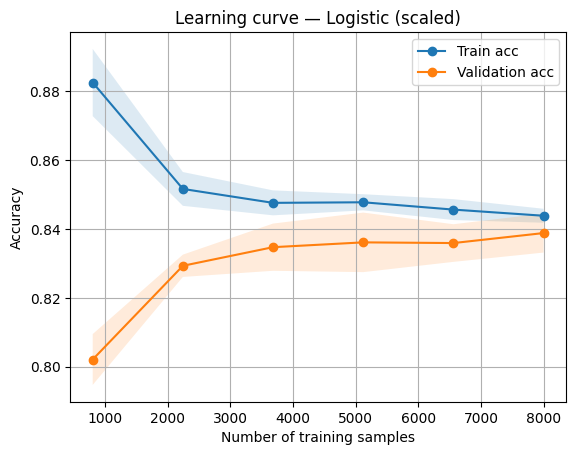

In [3]:
# === Cell A: overfitting diagnostics (learning curve) ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold, learning_curve, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

def diagnose_overfitting(
    X, y,
    cv_splits: int = 5,
    train_sizes = np.linspace(0.1, 1.0, 6),
    random_state: int = 42,
    max_iter: int = 1000,
    plot: bool = True
):
    """
    Computes a learning curve for a Logistic Regression pipeline (Scaler + Logistic).
    Returns a dict with summary stats and optionally plots train vs validation accuracy.
    """
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(max_iter=max_iter, random_state=random_state))
    ])

    cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=random_state)

    # learning_curve supports shuffle/random_state in recent sklearn versions
    ts_abs, train_scores, val_scores = learning_curve(
        estimator=pipe,
        X=X, y=y,
        train_sizes=train_sizes,
        cv=cv,
        scoring="accuracy",
        shuffle=True,
        random_state=random_state,
        n_jobs=-1
    )

    train_mean = train_scores.mean(axis=1)
    train_std  = train_scores.std(axis=1)
    val_mean   = val_scores.mean(axis=1)
    val_std    = val_scores.std(axis=1)

    # Table view
    df_lc = pd.DataFrame({
        "train_size": ts_abs,
        "train_acc_mean": train_mean,
        "train_acc_std": train_std,
        "val_acc_mean": val_mean,
        "val_acc_std": val_std,
        "gap_train_minus_val": train_mean - val_mean
    })
    display(df_lc)

    # Simple decision rule for potential overfitting (gap at largest size)
    gap_last = float(df_lc["gap_train_minus_val"].iloc[-1])
    val_last = float(df_lc["val_acc_mean"].iloc[-1])
    flag_overfit = (gap_last >= 0.05) and (val_last < 0.80 or gap_last > 0.07)

    print(f"\nLargest train size = {int(ts_abs[-1])}")
    print(f"  • Train acc (mean): {train_mean[-1]:.4f}")
    print(f"  • Val   acc (mean): {val_mean[-1]:.4f}")
    print(f"  • Gap (train - val): {gap_last:.4f}")
    print(f"\nPotential overfitting: {'YES' if flag_overfit else 'NO'}")

    if plot:
        plt.figure()
        plt.plot(ts_abs, train_mean, marker="o", label="Train acc")
        plt.fill_between(ts_abs, train_mean-train_std, train_mean+train_std, alpha=0.15)
        plt.plot(ts_abs, val_mean, marker="o", label="Validation acc")
        plt.fill_between(ts_abs, val_mean-val_std, val_mean+val_std, alpha=0.15)
        plt.xlabel("Number of training samples")
        plt.ylabel("Accuracy")
        plt.title("Learning curve — Logistic (scaled)")
        plt.legend()
        plt.grid(True)
        plt.show()

    return {
        "train_sizes": ts_abs,
        "train_acc_mean": train_mean,
        "val_acc_mean": val_mean,
        "gap_last": gap_last,
        "val_last": val_last,
        "overfitting_flag": flag_overfit
    }

# --- How to call (run after Cell 2) ---
features = [c for c in train_df.columns if c not in ("battle_id", "player_won")]
X = train_df[features].values
y = train_df["player_won"].values
_ = diagnose_overfitting(X, y, cv_splits=5, max_iter=1000, plot=True)

# 3. Models Training

## 3.1 - Best Features Selection, V.3 (Elastic Net + SelectFromModel)

In [4]:
# === 3.1 BEST FEATURES SELECTION (Elastic Net + SelectFromModel) ==================
# - Prints original feature count
# - Train-only pruning:
#     (A) correlation pruning (|ρ| > 0.95)
#     (C) optional robust VIF pruning (iterative, safe)
# - Selector: Elastic Net (LogisticRegressionCV, saga) + SelectFromModel with a small threshold sweep
# - Outputs: train_reduced, test_reduced with the exact selected feature subset
# ================================================================================

import numpy as np
import pandas as pd
from typing import List, Tuple

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score

# -----------------------
# Config
# -----------------------
RANDOM_STATE = 42
ID_COLS      = ["battle_id"]
TARGET_COL   = "player_won"
DROP_VIF     = True           # set to False to skip VIF pruning
VIF_THRESHOLD= 25.0           # robust, not too aggressive
MAX_VIF_STEPS= 50             # safety cap
CORR_THR     = 0.99           # correlation pruning threshold (abs Pearson)
NEAR_CONST_P = 0.002        # near-constant if <1% distinct values
CV_SPLITS    = 5

assert TARGET_COL in train_df.columns, f"Target '{TARGET_COL}' not found in train_df."

# -----------------------
# 0) Build numeric matrices
# -----------------------
num_cols_all = [c for c in train_df.columns if c not in (TARGET_COL, *ID_COLS)]
X = train_df[num_cols_all].copy()
y = train_df[TARGET_COL].astype(int).copy()
X_test_full = test_df[num_cols_all].copy()

# ensure numeric dtype (and keep NaN)
X = X.apply(pd.to_numeric, errors="coerce").astype("float32")
X_test_full = X_test_full.apply(pd.to_numeric, errors="coerce").astype("float32")

orig_feat_count = X.shape[1]
print(f"[Info] Original feature count (numeric, pre-pruning): {orig_feat_count}")

# -----------------------
# Helper: simple impute/scale (fit on TRAIN only)
# -----------------------
def fit_imputer_scaler(df: pd.DataFrame):
    imp = SimpleImputer(strategy="median")
    sca = RobustScaler()
    Z   = imp.fit_transform(df)
    Z   = sca.fit_transform(Z)
    return imp, sca, Z

# -----------------------
# (A) Constants 
# -----------------------
# constants: zero variance on observed values (ignoring NaN)
const_cols = [c for c in X.columns if X[c].nunique(dropna=True) <= 1]

print(f"[Pruning][A] Constant features removed: {len(const_cols)}")
if const_cols:
    print("  -> Constant list (first 50):", const_cols[:50])

drop_A = const_cols
if drop_A:
    X.drop(columns=drop_A, inplace=True, errors="ignore")
    X_test_full.drop(columns=drop_A, inplace=True, errors="ignore")

print(f"[Pruning][A] After constant pruning: {X.shape[1]} features")

# -----------------------
# (B) Correlation pruning (|ρ| > CORR_THR)
# -----------------------
# compute correlation on imputed values to avoid NaNs
imp_tmp = SimpleImputer(strategy="median").fit(X)
X_imp = pd.DataFrame(imp_tmp.transform(X), columns=X.columns, index=X.index)

corr = X_imp.corr(method="pearson").abs()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
to_drop_corr = [col for col in upper.columns if any(upper[col] > CORR_THR)]

if to_drop_corr:
    print(f"[Pruning][B] Dropped for high correlation (>|ρ| {CORR_THR}): {len(to_drop_corr)}")
    X.drop(columns=to_drop_corr, inplace=True, errors="ignore")
    X_test_full.drop(columns=to_drop_corr, inplace=True, errors="ignore")
else:
    print("[Pruning][B] No features dropped by correlation threshold.")

print(f"[Pruning][B] After correlation pruning: {X.shape[1]} features")

# -----------------------
# (C) Optional robust VIF pruning (iterative)
# -----------------------
def compute_vif_frame(df_std: pd.DataFrame) -> pd.DataFrame:
    """
    Compute VIF using a standard OLS-based formula on standardized, imputed data.
    Returns a DataFrame with columns ['feature','vif'].
    """
    # classic VIF formula via linear regressions:
    # to avoid heavy statsmodels dependency & to keep it robust/fast, we use sklearn OLS fallback
    from sklearn.linear_model import LinearRegression
    cols = list(df_std.columns)
    vifs = []
    for i, col in enumerate(cols):
        yv = df_std[col].values
        Xv = df_std.drop(columns=[col]).values
        # handle degenerate case: one or zero columns left
        if Xv.shape[1] == 0:
            vifs.append(np.inf)
            continue
        # fit OLS
        lr = LinearRegression(n_jobs=None)  # OLS via least squares
        lr.fit(Xv, yv)
        yhat = lr.predict(Xv)
        # R^2
        ss_res = np.sum((yv - yhat)**2)
        ss_tot = np.sum((yv - np.mean(yv))**2) + 1e-12
        r2 = 1.0 - ss_res / ss_tot
        # VIF
        if r2 >= 0.999999:
            vif_val = np.inf
        else:
            vif_val = 1.0 / max(1e-12, (1.0 - r2))
        vifs.append(vif_val)
    return pd.DataFrame({"feature": cols, "vif": vifs})

vif_dropped = []
if DROP_VIF and X.shape[1] > 2:
    print(f"[Pruning][C] Starting VIF pruning (thr={VIF_THRESHOLD}, max steps={MAX_VIF_STEPS}) ...")
    step = 0
    while step < MAX_VIF_STEPS and X.shape[1] > 2:
        # refit imputer & scaler on current columns each iteration (avoids feature-name mismatch)
        imp_vif, sca_vif, X_std = fit_imputer_scaler(X)
        X_std = pd.DataFrame(X_std, columns=X.columns, index=X.index)

        vif_frame = compute_vif_frame(X_std)
        max_row = vif_frame.loc[vif_frame["vif"].idxmax()]
        max_feat, max_vif = str(max_row["feature"]), float(max_row["vif"])

        if not np.isfinite(max_vif):
            # drop the one producing inf VIF
            print(f"  [VIF] Step {step+1}: dropping '{max_feat}' (VIF=inf)")
            vif_dropped.append(max_feat)
            X.drop(columns=[max_feat], inplace=True, errors="ignore")
            X_test_full.drop(columns=[max_feat], inplace=True, errors="ignore")
            step += 1
            continue

        if max_vif <= VIF_THRESHOLD:
            print(f"  [VIF] All VIF <= {VIF_THRESHOLD:.1f} (max={max_vif:.2f}). Stopping.")
            break

        print(f"  [VIF] Step {step+1}: dropping '{max_feat}' (VIF={max_vif:.2f})")
        vif_dropped.append(max_feat)
        X.drop(columns=[max_feat], inplace=True, errors="ignore")
        X_test_full.drop(columns=[max_feat], inplace=True, errors="ignore")
        step += 1

    print(f"[Pruning][C] VIF dropped: {len(vif_dropped)}")
else:
    print("[Pruning][C] VIF pruning skipped.")

print(f"[Pruning] After A+B(+C): {X.shape[1]} features")

feat_cols_after_pruning = list(X.columns)

# -----------------------
# Elastic Net selector (LogisticRegressionCV, saga)
# -----------------------
cv = StratifiedKFold(n_splits=CV_SPLITS, shuffle=True, random_state=RANDOM_STATE)

# Fit imputer & scaler on TRAIN (post-pruning)
imp_sel, sca_sel, X_std_sel = fit_imputer_scaler(X)

# ENet with CV on Cs and l1 ratios
enet = LogisticRegressionCV(
    penalty="elasticnet",
    solver="saga",
    Cs=[0.05, 0.1, 0.2, 0.5, 1.0],
    l1_ratios=[0.1, 0.3, 0.5, 0.7],
    scoring="accuracy",
    cv=cv,
    max_iter=5000,
    tol=1e-3,
    n_jobs=-1,
    refit=True,
    random_state=RANDOM_STATE
)
enet.fit(X_std_sel, y)

# --- Top-N selection by absolute EN coefficients (replaces SelectFromModel sweep) ---
TARGET_N_FEATURES = 60  # <- set your desired count

# 1) Get absolute coefficients from the fitted CV ElasticNet (binary -> shape (1, n_features))
abs_w = np.abs(enet.coef_.ravel())

# 2) If too few non-zeros, gently relax by re-fitting once with larger C or lower l1_ratio
nonzero_idx = np.where(abs_w > 0)[0]
if nonzero_idx.size < TARGET_N_FEATURES:
    # pick relaxed hyperparams from the best CV solution
    relaxed_C = float(enet.C_[0] * 2.0)
    relaxed_l1 = max(0.2, float(enet.l1_ratio_[0]) - 0.1)

    enet_relaxed = LogisticRegressionCV(
        penalty="elasticnet",
        solver="saga",
        Cs=[relaxed_C],
        l1_ratios=[relaxed_l1],
        scoring="accuracy",
        cv=cv,
        max_iter=6000,
        tol=1e-3,
        n_jobs=-1,
        refit=True,
        random_state=RANDOM_STATE
    )
    enet_relaxed.fit(X_std_sel, y)
    enet = enet_relaxed
    abs_w = np.abs(enet.coef_.ravel())
    nonzero_idx = np.where(abs_w > 0)[0]

# 3) Pick TOP-N by absolute weight (guarantees desired count when possible)
n_take = min(TARGET_N_FEATURES, abs_w.size)
thresh_val = np.partition(abs_w, -n_take)[-n_take]
top_mask = abs_w >= thresh_val

selected_cols = list(np.array(feat_cols_after_pruning)[top_mask])
print(f"[ElasticNet+TopN] Non-zero weights: {nonzero_idx.size} | Selected top-{n_take}: {len(selected_cols)}")

# 4) Build reduced DataFrames (RAW view for downstream cells)
train_reduced = pd.concat(
    [train_df[ID_COLS], train_df[[TARGET_COL]], train_df[selected_cols]],
    axis=1
)
test_reduced = pd.concat(
    [test_df[ID_COLS], test_df[selected_cols]],
    axis=1
)

print(f"[Output] train_reduced shape: {train_reduced.shape} | test_reduced shape: {test_reduced.shape}")
print(f"[Features] Final selected ({len(selected_cols)}): first 25 -> {selected_cols[:25]}")


[Info] Original feature count (numeric, pre-pruning): 215
[Pruning][A] Constant features removed: 43
  -> Constant list (first 50): ['p1_team_size', 'p2_team_size', 'p2_unique_types', 'diff_team_size', 'tl_turns_used', 'tl_hp_diff_min', 'tl_p1_status_count', 'tl_p2_status_count', 'tl_status_count', 'hazard_switch_pressure_diff', 'hazard_p1_flag', 'hazard_p2_flag', 'hazard_flag_diff', 'early_status_advantage_3', 'mv_p1_priority_count', 'mv_p2_priority_count', 'mv_priority_count_diff', 'mv_p1_priority_count_5', 'mv_p2_priority_count_5', 'mv_priority_count_diff_5', 'stronger_team', 'battle_length', 'long_battle', 'p1_hp_stability', 'p2_hp_stability', 'team_has_type_variety', 'p1_hp_over_50_ratio', 'p2_hp_over_50_ratio', 'is_player1_healthier', 'comeback_difficulty', 'damage_prediction', 'ix_speed_x_prio5', 'ix_early3_x_prio5', 'ix_hazards_x_prio5', 'atk_def_ratio', 'spd_gap', 'hp_ratio', 'survival_score', 'momentum_index', 'offensive_balance', 'defensive_efficiency', 'status_influence', '

/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


[Pruning][B] Dropped for high correlation (>|ρ| 0.99): 37
[Pruning][B] After correlation pruning: 135 features
[Pruning][C] Starting VIF pruning (thr=25.0, max steps=50) ...
  [VIF] Step 1: dropping 'p1_team_stat_sum' (VIF=inf)
  [VIF] Step 2: dropping 'p2_team_stat_sum' (VIF=inf)
  [VIF] Step 3: dropping 'p1_mean_spe' (VIF=inf)
  [VIF] Step 4: dropping 'p1_max_spe' (VIF=inf)
  [VIF] Step 5: dropping 'tl_p1_hp_last' (VIF=inf)
  [VIF] Step 6: dropping 'tl_p1_ko_count' (VIF=inf)
  [VIF] Step 7: dropping 'tl_p2_ko_count' (VIF=inf)
  [VIF] Step 8: dropping 'switch_p1_count' (VIF=inf)
  [VIF] Step 9: dropping 'recover_p1_count' (VIF=inf)
  [VIF] Step 10: dropping 'pokemon_remaining_diff' (VIF=inf)
  [VIF] Step 11: dropping 'avg_damage_p1' (VIF=inf)
  [VIF] Step 12: dropping 'used_pokemon_diff' (VIF=156734.55)
  [VIF] Step 13: dropping 'power_acc_gap' (VIF=532.65)
  [VIF] Step 14: dropping 'p2_lead_spe' (VIF=151.06)
  [VIF] Step 15: dropping 'tl_hp_diff_mean' (VIF=61.21)
  [VIF] Step 16: dro

## 3.2 - Stacking (Logistic Regression + XGBoost + Random Forest -> Logistic Regression meta)

In [5]:
# === 3.2 Stacking (LogisticRegression + XGBoost + RandomForest -> LogisticRegression meta) ===
# # - Uses true OOF stacking: base learners trained per fold, produce OOF probs
# # - XGBoost with early stopping (per-fold)
# # - RF and XGB calibrated with sigmoid on the validation fold (no leakage)
# # - Meta-learner = LogisticRegression (stable, well-calibrated on probs)
# # - Exposes: oof_meta_scores, meta_test_scores, y

# import numpy as np
# from sklearn.model_selection import StratifiedKFold
# from sklearn.pipeline import make_pipeline
# from sklearn.preprocessing import StandardScaler
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import accuracy_score, roc_auc_score
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.calibration import CalibratedClassifierCV

# import xgboost as xgb

# RANDOM_STATE = 99
# FOLDS = 10
# np.random.seed(RANDOM_STATE)

# # --- Safety checks & matrices ---
# assert "selected_cols" in globals(), "Run Cell 3.1 to define 'selected_cols'."
# assert "train_reduced" in globals() and "test_reduced" in globals(), "Missing reduced frames from 3.1."

# X_sel = train_reduced[selected_cols].to_numpy()
# X_test_sel = test_reduced[selected_cols].to_numpy()
# y = train_reduced["player_won"].astype(int).to_numpy()

# n_train = X_sel.shape[0]
# n_test  = X_test_sel.shape[0]

# print(f"[Stack LR+XGB+RF→LR] Using {X_sel.shape[1]} selected features on {n_train} training rows.")

# # --- Base learners -------------------------------------------------------------------------
# # (1) Logistic Regression (scaled). No calibration needed.
# base_lr = make_pipeline(
#     StandardScaler(),
#     LogisticRegression(
#         solver="liblinear",
#         penalty="l2",
#         C=0.5,
#         max_iter=3000,
#         random_state=RANDOM_STATE
#     )
# )

# # (2) XGBoost (with early stopping). We'll calibrate per-fold on the val fold.
# base_xgb_params = dict(
#     n_estimators=2000,           # high cap, early stopping will cut it
#     learning_rate=0.03,
#     max_depth=6,
#     subsample=0.8,
#     colsample_bytree=0.8,
#     reg_lambda=1.0,
#     reg_alpha=0.0,
#     objective="binary:logistic",
#     eval_metric="logloss",
#     random_state=RANDOM_STATE,
#     n_jobs=-1,
#     tree_method="hist"
# )

# # (3) Random Forest (regularized) + per-fold calibration
# base_rf = RandomForestClassifier(
#     n_estimators=400,
#     max_depth=10,
#     min_samples_leaf=10,
#     max_features="sqrt",
#     bootstrap=True,
#     n_jobs=-1,
#     random_state=RANDOM_STATE
# )

# base_names  = ["lr", "xgb", "rf"]
# n_base      = len(base_names)

# # --- OOF holders for base learners (level-1 features) --------------------------------------
# oof_base = np.zeros((n_train, n_base), dtype=float)
# test_base_folds = np.zeros((n_test, n_base, FOLDS), dtype=float)

# skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=RANDOM_STATE)

# print("\n[Per-fold validation summary]")
# for fold, (tr_idx, va_idx) in enumerate(skf.split(X_sel, y), 1):
#     X_tr, X_va = X_sel[tr_idx], X_sel[va_idx]
#     y_tr, y_va = y[tr_idx], y[va_idx]

#     # ---- Base 1: Logistic Regression (no calibration) ----
#     lr_model = make_pipeline(
#         StandardScaler(),
#         LogisticRegression(
#             solver="liblinear",
#             penalty="l2",
#             C=0.5,
#             max_iter=3000,
#             random_state=RANDOM_STATE
#         )
#     )
#     lr_model.fit(X_tr, y_tr)
#     lr_va = lr_model.predict_proba(X_va)[:, 1]
#     lr_te = lr_model.predict_proba(X_test_sel)[:, 1]

#     # ---- Base 2: XGBoost (early stopping) + sigmoid calibration on val ----
#     xgb_model = xgb.XGBClassifier(**base_xgb_params)
#     xgb_model.fit(
#         X_tr, y_tr,
#         eval_set=[(X_va, y_va)],
#         verbose=False
#     )

#     # predictions at best iteration (handle API differences safely)
#     try:
#         best_it = getattr(xgb_model, "best_iteration", None)
#         if best_it is not None:
#             xgb_va_raw = xgb_model.predict_proba(X_va, iteration_range=(0, best_it + 1))[:, 1]
#             xgb_te_raw = xgb_model.predict_proba(X_test_sel, iteration_range=(0, best_it + 1))[:, 1]
#         else:
#             xgb_va_raw = xgb_model.predict_proba(X_va)[:, 1]
#             xgb_te_raw = xgb_model.predict_proba(X_test_sel)[:, 1]
#         used_best = best_it
#     except Exception:
#         xgb_va_raw = xgb_model.predict_proba(X_va)[:, 1]
#         xgb_te_raw = xgb_model.predict_proba(X_test_sel)[:, 1]
#         used_best = "N/A"

#     # calibrate on the validation fold (no leakage)
#     xgb_cal = CalibratedClassifierCV(estimator=xgb_model, method="sigmoid", cv="prefit")
#     xgb_cal.fit(X_va, y_va)
#     xgb_va = xgb_cal.predict_proba(X_va)[:, 1]
#     xgb_te = xgb_cal.predict_proba(X_test_sel)[:, 1]

#     # ---- Base 3: Random Forest + sigmoid calibration on val ----
#     rf_model = RandomForestClassifier(
#         n_estimators=400,
#         max_depth=10,
#         min_samples_leaf=10,
#         max_features="sqrt",
#         bootstrap=True,
#         n_jobs=-1,
#         random_state=RANDOM_STATE + fold  # slight variation per fold
#     )
#     rf_model.fit(X_tr, y_tr)
#     rf_cal = CalibratedClassifierCV(estimator=rf_model, method="sigmoid", cv="prefit")
#     rf_cal.fit(X_va, y_va)
#     rf_va = rf_cal.predict_proba(X_va)[:, 1]
#     rf_te = rf_cal.predict_proba(X_test_sel)[:, 1]

#     # ---- Store OOF & per-fold test probs (level-1 design) ----
#     oof_base[va_idx, 0] = lr_va
#     oof_base[va_idx, 1] = xgb_va
#     oof_base[va_idx, 2] = rf_va

#     test_base_folds[:, 0, fold - 1] = lr_te
#     test_base_folds[:, 1, fold - 1] = xgb_te
#     test_base_folds[:, 2, fold - 1] = rf_te

#     # ---- Fold metrics (on validation) ----
#     # Report each base quickly (accuracy/AUC at 0.50)
#     def _rep(name, p):
#         acc = accuracy_score(y_va, (p >= 0.5).astype(int))
#         try:
#             auc = roc_auc_score(y_va, p)
#         except Exception:
#             auc = np.nan
#         return acc, auc

#     acc_lr, auc_lr   = _rep("lr",  lr_va)
#     acc_xgb, auc_xgb = _rep("xgb", xgb_va)
#     acc_rf, auc_rf   = _rep("rf",  rf_va)

#     print(f"  [Fold {fold}] "
#           f"LR  acc={acc_lr:.4f} | AUC={auc_lr:.4f}  ||  "
#           f"XGB acc={acc_xgb:.4f} | AUC={auc_xgb:.4f} | best_iter={used_best}  ||  "
#           f"RF  acc={acc_rf:.4f} | AUC={auc_rf:.4f}")

# # --- Aggregate test probs across folds for each base learner ---
# test_base_mean = test_base_folds.mean(axis=2)   # shape: (n_test, 3)

# # --- Meta-learner on OOF base features (with second-level OOF for honest estimate) ----------
# meta_clf = LogisticRegression(
#     solver="lbfgs",
#     penalty="l2",
#     C=1.0,
#     max_iter=5000,
#     random_state=RANDOM_STATE
# )

# # Build true OOF for meta as well
# oof_meta_scores = np.zeros(n_train, dtype=float)
# meta_test_folds = np.zeros((n_test, FOLDS), dtype=float)

# skf_meta = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=RANDOM_STATE + 1)
# for fold, (tr_idx, va_idx) in enumerate(skf_meta.split(oof_base, y), 1):
#     X_tr_m, X_va_m = oof_base[tr_idx], oof_base[va_idx]
#     y_tr_m, y_va_m = y[tr_idx], y[va_idx]

#     meta_clf_fold = LogisticRegression(
#         solver="lbfgs",
#         penalty="l2",
#         C=1.0,
#         max_iter=5000,
#         random_state=RANDOM_STATE + fold
#     )
#     meta_clf_fold.fit(X_tr_m, y_tr_m)
#     oof_meta_scores[va_idx] = meta_clf_fold.predict_proba(X_va_m)[:, 1]
#     meta_test_folds[:, fold - 1] = meta_clf_fold.predict_proba(test_base_mean)[:, 1]

# # Final meta on full OOF (optional fit, used for reporting and stability)
# meta_clf.fit(oof_base, y)
# meta_test_scores = meta_test_folds.mean(axis=1)

# # --- Quick OOF report for the stacked meta predictor ---
# oof_acc_default = accuracy_score(y, (oof_meta_scores >= 0.50).astype(int))
# try:
#     oof_auc = roc_auc_score(y, oof_meta_scores)
# except Exception:
#     oof_auc = np.nan

# print("\n[OOF][Meta LR] Accuracy @ 0.50 = {:.4f}".format(oof_acc_default))
# print("[OOF][Meta LR] ROC-AUC = {:.4f}".format(oof_auc))
# print("\nReady for 3.3 threshold tuning (variables: oof_meta_scores, meta_test_scores, y)")


In [6]:
# import numpy as np
# from sklearn.model_selection import StratifiedKFold
# from sklearn.pipeline import make_pipeline
# from sklearn.preprocessing import StandardScaler
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import accuracy_score, roc_auc_score
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.calibration import CalibratedClassifierCV

# import xgboost as xgb

# # ===============================================================
# # MULTI-SEED ENSEMBLE WRAPPER
# # ===============================================================

# SEEDS = [11, 42, 77, 99, 123]
# results = []

# for seed in SEEDS:
#     print("\n" + "="*80)
#     print(f"Running stacking with RANDOM_STATE = {seed}")
#     print("="*80)

#     # global random seed
#     RANDOM_STATE = seed
#     np.random.seed(RANDOM_STATE)
#     META_RANDOM_STATE = 42
#     np.random.seed(META_RANDOM_STATE)
#     FOLDS = 10

#     # orginal block stars from here <------
#     assert "selected_cols" in globals(), "Run Cell 3.1 to define 'selected_cols'."
#     assert "train_reduced" in globals() and "test_reduced" in globals(), "Missing reduced frames from 3.1."
    
#     X_sel = train_reduced[selected_cols].to_numpy()
#     X_test_sel = test_reduced[selected_cols].to_numpy()
#     y = train_reduced["player_won"].astype(int).to_numpy()
    
#     n_train = X_sel.shape[0]
#     n_test  = X_test_sel.shape[0]
    
#     print(f"[Stack LR+XGB+RF→LR] Using {X_sel.shape[1]} selected features on {n_train} training rows.")
    
#     # --- Base learners -------------------------------------------------------------------------
#     # (1) Logistic Regression (scaled). No calibration needed.
#     base_lr = make_pipeline(
#         StandardScaler(),
#         LogisticRegression(
#             solver="liblinear",
#             penalty="l2",
#             C=0.5,
#             max_iter=3000,
#             random_state=RANDOM_STATE
#         )
#     )
    
#     # (2) XGBoost (with early stopping). We'll calibrate per-fold on the val fold.
#     base_xgb_params = dict(
#         n_estimators=2000,           # high cap, early stopping will cut it
#         learning_rate=0.03,
#         max_depth=6,
#         subsample=0.8,
#         colsample_bytree=0.8,
#         reg_lambda=1.0,
#         reg_alpha=0.0,
#         objective="binary:logistic",
#         eval_metric="logloss",
#         random_state=RANDOM_STATE,
#         n_jobs=-1,
#         tree_method="hist"
#     )
    
#     # (3) Random Forest (regularized) + per-fold calibration
#     base_rf = RandomForestClassifier(
#         n_estimators=400,
#         max_depth=10,
#         min_samples_leaf=10,
#         max_features="sqrt",
#         bootstrap=True,
#         n_jobs=-1,
#         random_state=RANDOM_STATE
#     )
    
#     base_names  = ["lr", "xgb", "rf"]
#     n_base      = len(base_names)
    
#     # --- OOF holders for base learners (level-1 features) --------------------------------------
#     oof_base = np.zeros((n_train, n_base), dtype=float)
#     test_base_folds = np.zeros((n_test, n_base, FOLDS), dtype=float)
    
#     skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=RANDOM_STATE)
    
#     print("\n[Per-fold validation summary]")
#     for fold, (tr_idx, va_idx) in enumerate(skf.split(X_sel, y), 1):
#         X_tr, X_va = X_sel[tr_idx], X_sel[va_idx]
#         y_tr, y_va = y[tr_idx], y[va_idx]
    
#         # ---- Base 1: Logistic Regression (no calibration) ----
#         lr_model = make_pipeline(
#             StandardScaler(),
#             LogisticRegression(
#                 solver="liblinear",
#                 penalty="l2",
#                 C=0.5,
#                 max_iter=3000,
#                 random_state=RANDOM_STATE
#             )
#         )
#         lr_model.fit(X_tr, y_tr)
#         lr_va = lr_model.predict_proba(X_va)[:, 1]
#         lr_te = lr_model.predict_proba(X_test_sel)[:, 1]
    
#         # ---- Base 2: XGBoost (early stopping) + sigmoid calibration on val ----
#         xgb_model = xgb.XGBClassifier(**base_xgb_params)
#         xgb_model.fit(
#             X_tr, y_tr,
#             eval_set=[(X_va, y_va)],
#             verbose=False
#         )
    
#         # predictions at best iteration (handle API differences safely)
#         try:
#             best_it = getattr(xgb_model, "best_iteration", None)
#             if best_it is not None:
#                 xgb_va_raw = xgb_model.predict_proba(X_va, iteration_range=(0, best_it + 1))[:, 1]
#                 xgb_te_raw = xgb_model.predict_proba(X_test_sel, iteration_range=(0, best_it + 1))[:, 1]
#             else:
#                 xgb_va_raw = xgb_model.predict_proba(X_va)[:, 1]
#                 xgb_te_raw = xgb_model.predict_proba(X_test_sel)[:, 1]
#             used_best = best_it
#         except Exception:
#             xgb_va_raw = xgb_model.predict_proba(X_va)[:, 1]
#             xgb_te_raw = xgb_model.predict_proba(X_test_sel)[:, 1]
#             used_best = "N/A"
    
#         # calibrate on the validation fold (no leakage)
#         xgb_cal = CalibratedClassifierCV(estimator=xgb_model, method="sigmoid", cv="prefit")
#         xgb_cal.fit(X_va, y_va)
#         xgb_va = xgb_cal.predict_proba(X_va)[:, 1]
#         xgb_te = xgb_cal.predict_proba(X_test_sel)[:, 1]
    
#         # ---- Base 3: Random Forest + sigmoid calibration on val ----
#         rf_model = RandomForestClassifier(
#             n_estimators=400,
#             max_depth=10,
#             min_samples_leaf=10,
#             max_features="sqrt",
#             bootstrap=True,
#             n_jobs=-1,
#             random_state=RANDOM_STATE + fold  # slight variation per fold
#         )
#         rf_model.fit(X_tr, y_tr)
#         rf_cal = CalibratedClassifierCV(estimator=rf_model, method="sigmoid", cv="prefit")
#         rf_cal.fit(X_va, y_va)
#         rf_va = rf_cal.predict_proba(X_va)[:, 1]
#         rf_te = rf_cal.predict_proba(X_test_sel)[:, 1]
    
#         # ---- Store OOF & per-fold test probs (level-1 design) ----
#         oof_base[va_idx, 0] = lr_va
#         oof_base[va_idx, 1] = xgb_va
#         oof_base[va_idx, 2] = rf_va
    
#         test_base_folds[:, 0, fold - 1] = lr_te
#         test_base_folds[:, 1, fold - 1] = xgb_te
#         test_base_folds[:, 2, fold - 1] = rf_te
    
#         # ---- Fold metrics (on validation) ----
#         # Report each base quickly (accuracy/AUC at 0.50)
#         def _rep(name, p):
#             acc = accuracy_score(y_va, (p >= 0.5).astype(int))
#             try:
#                 auc = roc_auc_score(y_va, p)
#             except Exception:
#                 auc = np.nan
#             return acc, auc
    
#         acc_lr, auc_lr   = _rep("lr",  lr_va)
#         acc_xgb, auc_xgb = _rep("xgb", xgb_va)
#         acc_rf, auc_rf   = _rep("rf",  rf_va)
    
#         print(f"  [Fold {fold}] "
#               f"LR  acc={acc_lr:.4f} | AUC={auc_lr:.4f}  ||  "
#               f"XGB acc={acc_xgb:.4f} | AUC={auc_xgb:.4f} | best_iter={used_best}  ||  "
#               f"RF  acc={acc_rf:.4f} | AUC={auc_rf:.4f}")
    
#     # --- Aggregate test probs across folds for each base learner ---
#     test_base_mean = test_base_folds.mean(axis=2)   # shape: (n_test, 3)
    
#     # --- Meta-learner on OOF base features (with second-level OOF for honest estimate) ----------
#     meta_clf = LogisticRegression(
#         solver="lbfgs",
#         penalty="l2",
#         C=1.0,
#         max_iter=5000,
#         random_state=META_RANDOM_STATE
#     )
    
#     # Build true OOF for meta as well
#     oof_meta_scores = np.zeros(n_train, dtype=float)
#     meta_test_folds = np.zeros((n_test, FOLDS), dtype=float)
    
#     skf_meta = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=META_RANDOM_STATE + 1)
#     for fold, (tr_idx, va_idx) in enumerate(skf_meta.split(oof_base, y), 1):
#         X_tr_m, X_va_m = oof_base[tr_idx], oof_base[va_idx]
#         y_tr_m, y_va_m = y[tr_idx], y[va_idx]
    
#         meta_clf_fold = LogisticRegression(
#             solver="lbfgs",
#             penalty="l2",
#             C=1.0,
#             max_iter=5000,
#             random_state=META_RANDOM_STATE + fold
#         )
#         meta_clf_fold.fit(X_tr_m, y_tr_m)
#         oof_meta_scores[va_idx] = meta_clf_fold.predict_proba(X_va_m)[:, 1]
#         meta_test_folds[:, fold - 1] = meta_clf_fold.predict_proba(test_base_mean)[:, 1]
    
#     # Final meta on full OOF (optional fit, used for reporting and stability)
#     meta_clf.fit(oof_base, y)
#     meta_test_scores = meta_test_folds.mean(axis=1)
    
#     # --- Quick OOF report for the stacked meta predictor ---
#     oof_acc_default = accuracy_score(y, (oof_meta_scores >= 0.50).astype(int))
#     try:
#         oof_auc = roc_auc_score(y, oof_meta_scores)
#     except Exception:
#         oof_auc = np.nan
    
#     print("\n[OOF][Meta LR] Accuracy @ 0.50 = {:.4f}".format(oof_acc_default))
#     print("[OOF][Meta LR] ROC-AUC = {:.4f}".format(oof_auc))

#     results.append({
#         "seed": seed,
#         "auc": oof_auc,
#         "y": y,
#         "oof_meta_scores": oof_meta_scores,
#         "meta_test_scores": meta_test_scores
#     })

# # ===============================================================
# # BEST MODEL
# # ===============================================================
# best_result = max(results, key=lambda x: x["auc"])
# best_seed = best_result["seed"]
# best_auc = best_result["auc"]

# y = best_result["y"]
# oof_meta_scores = best_result["oof_meta_scores"]
# meta_test_scores = best_result["meta_test_scores"]

# print("\n" + "="*90)
# print(f"Best model found with RANDOM_STATE = {best_seed}")
# print(f"Best OOF AUC = {best_auc:.4f}")
# print("="*90)
# print("\nReady for 3.3 threshold tuning (variables: oof_meta_scores, meta_test_scores, y)")



In [7]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV

import xgboost as xgb

# ===============================================================
# MULTI-SEED ENSEMBLE WRAPPER
# ===============================================================

SEEDS = [
    (99, 99, 99),
    (99,99, 200),
    (99, 99, 110),
    (70, 80, 200),
    (65, 50, 250),
    (90, 75, 180),
    (60, 85, 220),
    (50, 55, 160),
    (80, 70, 210),
    (75, 65, 190),
]
results = []

for idx, (seed_lr, seed_xgb, seed_rf) in enumerate(SEEDS, 1):
    print("\n" + "="*90)
    print(f"Running stacking iteration {idx}")
    print(f"LR_seed={seed_lr}, XGB_seed={seed_xgb}, RF_seed={seed_rf}")
    print("="*90)

    # global random seed
    META_RANDOM_STATE = 42
    np.random.seed(META_RANDOM_STATE)
    FOLDS = 10

    # orginal block stars from here <------
    assert "selected_cols" in globals(), "Run Cell 3.1 to define 'selected_cols'."
    assert "train_reduced" in globals() and "test_reduced" in globals(), "Missing reduced frames from 3.1."
    
    X_sel = train_reduced[selected_cols].to_numpy()
    X_test_sel = test_reduced[selected_cols].to_numpy()
    y = train_reduced["player_won"].astype(int).to_numpy()
    
    n_train = X_sel.shape[0]
    n_test  = X_test_sel.shape[0]
    
    print(f"[Stack LR+XGB+RF→LR] Using {X_sel.shape[1]} selected features on {n_train} training rows.")
    
    # --- Base learners -------------------------------------------------------------------------
    # (1) Logistic Regression (scaled). No calibration needed.
    base_lr = make_pipeline(
        StandardScaler(),
        LogisticRegression(
            solver="liblinear",
            penalty="l2",
            C=0.5,
            max_iter=3000,
            random_state=seed_lr
        )
    )
    
    # (2) XGBoost (with early stopping). We'll calibrate per-fold on the val fold.
    base_xgb_params = dict(
        n_estimators=2000,           # high cap, early stopping will cut it
        learning_rate=0.03,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        reg_alpha=0.0,
        objective="binary:logistic",
        eval_metric="logloss",
        random_state=seed_xgb,
        n_jobs=-1,
        tree_method="hist"
    )
    
    # (3) Random Forest (regularized) + per-fold calibration
    base_rf = RandomForestClassifier(
        n_estimators=400,
        max_depth=10,
        min_samples_leaf=10,
        max_features="sqrt",
        bootstrap=True,
        n_jobs=-1,
        random_state=seed_rf
    )
    
    base_names  = ["lr", "xgb", "rf"]
    n_base      = len(base_names)
    
    # --- OOF holders for base learners (level-1 features) --------------------------------------
    oof_base = np.zeros((n_train, n_base), dtype=float)
    test_base_folds = np.zeros((n_test, n_base, FOLDS), dtype=float)
    
    skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=RANDOM_STATE)
    
    print("\n[Per-fold validation summary]")
    for fold, (tr_idx, va_idx) in enumerate(skf.split(X_sel, y), 1):
        X_tr, X_va = X_sel[tr_idx], X_sel[va_idx]
        y_tr, y_va = y[tr_idx], y[va_idx]
    
        # ---- Base 1: Logistic Regression (no calibration) ----
        lr_model = make_pipeline(
            StandardScaler(),
            LogisticRegression(
                solver="liblinear",
                penalty="l2",
                C=0.5,
                max_iter=3000,
                random_state=seed_lr
            )
        )
        lr_model.fit(X_tr, y_tr)
        lr_va = lr_model.predict_proba(X_va)[:, 1]
        lr_te = lr_model.predict_proba(X_test_sel)[:, 1]
    
        # ---- Base 2: XGBoost (early stopping) + sigmoid calibration on val ----
        xgb_model = xgb.XGBClassifier(**base_xgb_params)
        xgb_model.fit(
            X_tr, y_tr,
            eval_set=[(X_va, y_va)],
            verbose=False
        )
    
        # predictions at best iteration (handle API differences safely)
        try:
            best_it = getattr(xgb_model, "best_iteration", None)
            if best_it is not None:
                xgb_va_raw = xgb_model.predict_proba(X_va, iteration_range=(0, best_it + 1))[:, 1]
                xgb_te_raw = xgb_model.predict_proba(X_test_sel, iteration_range=(0, best_it + 1))[:, 1]
            else:
                xgb_va_raw = xgb_model.predict_proba(X_va)[:, 1]
                xgb_te_raw = xgb_model.predict_proba(X_test_sel)[:, 1]
            used_best = best_it
        except Exception:
            xgb_va_raw = xgb_model.predict_proba(X_va)[:, 1]
            xgb_te_raw = xgb_model.predict_proba(X_test_sel)[:, 1]
            used_best = "N/A"
    
        # calibrate on the validation fold (no leakage)
        xgb_cal = CalibratedClassifierCV(estimator=xgb_model, method="sigmoid", cv="prefit")
        xgb_cal.fit(X_va, y_va)
        xgb_va = xgb_cal.predict_proba(X_va)[:, 1]
        xgb_te = xgb_cal.predict_proba(X_test_sel)[:, 1]
    
        # ---- Base 3: Random Forest + sigmoid calibration on val ----
        rf_model = RandomForestClassifier(
            n_estimators=400,
            max_depth=10,
            min_samples_leaf=10,
            max_features="sqrt",
            bootstrap=True,
            n_jobs=-1,
            random_state=seed_rf + fold  # slight variation per fold
        )
        rf_model.fit(X_tr, y_tr)
        rf_cal = CalibratedClassifierCV(estimator=rf_model, method="sigmoid", cv="prefit")
        rf_cal.fit(X_va, y_va)
        rf_va = rf_cal.predict_proba(X_va)[:, 1]
        rf_te = rf_cal.predict_proba(X_test_sel)[:, 1]
    
        # ---- Store OOF & per-fold test probs (level-1 design) ----
        oof_base[va_idx, 0] = lr_va
        oof_base[va_idx, 1] = xgb_va
        oof_base[va_idx, 2] = rf_va
    
        test_base_folds[:, 0, fold - 1] = lr_te
        test_base_folds[:, 1, fold - 1] = xgb_te
        test_base_folds[:, 2, fold - 1] = rf_te
    
        # ---- Fold metrics (on validation) ----
        # Report each base quickly (accuracy/AUC at 0.50)
        def _rep(name, p):
            acc = accuracy_score(y_va, (p >= 0.5).astype(int))
            try:
                auc = roc_auc_score(y_va, p)
            except Exception:
                auc = np.nan
            return acc, auc
    
        acc_lr, auc_lr   = _rep("lr",  lr_va)
        acc_xgb, auc_xgb = _rep("xgb", xgb_va)
        acc_rf, auc_rf   = _rep("rf",  rf_va)
    
        print(f"  [Fold {fold}] "
              f"LR  acc={acc_lr:.4f} | AUC={auc_lr:.4f}  ||  "
              f"XGB acc={acc_xgb:.4f} | AUC={auc_xgb:.4f} | best_iter={used_best}  ||  "
              f"RF  acc={acc_rf:.4f} | AUC={auc_rf:.4f}")
    
    # --- Aggregate test probs across folds for each base learner ---
    test_base_mean = test_base_folds.mean(axis=2)   # shape: (n_test, 3)
    
    # --- Meta-learner on OOF base features (with second-level OOF for honest estimate) ----------
    meta_clf = LogisticRegression(
        solver="lbfgs",
        penalty="l2",
        C=1.0,
        max_iter=5000,
        random_state=META_RANDOM_STATE
    )
    
    # Build true OOF for meta as well
    oof_meta_scores = np.zeros(n_train, dtype=float)
    meta_test_folds = np.zeros((n_test, FOLDS), dtype=float)
    
    skf_meta = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=META_RANDOM_STATE + 1)
    for fold, (tr_idx, va_idx) in enumerate(skf_meta.split(oof_base, y), 1):
        X_tr_m, X_va_m = oof_base[tr_idx], oof_base[va_idx]
        y_tr_m, y_va_m = y[tr_idx], y[va_idx]
    
        meta_clf_fold = LogisticRegression(
            solver="lbfgs",
            penalty="l2",
            C=1.0,
            max_iter=5000,
            random_state=META_RANDOM_STATE + fold
        )
        meta_clf_fold.fit(X_tr_m, y_tr_m)
        oof_meta_scores[va_idx] = meta_clf_fold.predict_proba(X_va_m)[:, 1]
        meta_test_folds[:, fold - 1] = meta_clf_fold.predict_proba(test_base_mean)[:, 1]
    
    # Final meta on full OOF (optional fit, used for reporting and stability)
    meta_clf.fit(oof_base, y)
    meta_test_scores = meta_test_folds.mean(axis=1)
    
    # --- Quick OOF report for the stacked meta predictor ---
    oof_acc_default = accuracy_score(y, (oof_meta_scores >= 0.50).astype(int))
    try:
        oof_auc = roc_auc_score(y, oof_meta_scores)
    except Exception:
        oof_auc = np.nan
    
    print("\n[OOF][Meta LR] Accuracy @ 0.50 = {:.4f}".format(oof_acc_default))
    print("[OOF][Meta LR] ROC-AUC = {:.4f}".format(oof_auc))

    results.append({
        "seed": f"LR_seed={seed_lr}, XGB_seed={seed_xgb}, RF_seed={seed_rf}",
        "auc": oof_auc,
        "y": y,
        "oof_meta_scores": oof_meta_scores,
        "meta_test_scores": meta_test_scores
    })

# ===============================================================
# BEST MODEL
# ===============================================================
best_result = max(results, key=lambda x: x["auc"])
best_seed = best_result["seed"]
best_auc = best_result["auc"]

y = best_result["y"]
oof_meta_scores = best_result["oof_meta_scores"]
meta_test_scores = best_result["meta_test_scores"]

print("\n" + "="*90)
print(f"Best model found with {best_seed}")
print(f"Best OOF AUC = {best_auc:.4f}")
print("="*90)
print("\nReady for 3.3 threshold tuning (variables: oof_meta_scores, meta_test_scores, y)")


Running stacking iteration 1
LR_seed=99, XGB_seed=99, RF_seed=99
[Stack LR+XGB+RF→LR] Using 60 selected features on 10000 training rows.

[Per-fold validation summary]
  [Fold 1] LR  acc=0.8310 | AUC=0.8916  ||  XGB acc=0.8190 | AUC=0.8849 | best_iter=None  ||  RF  acc=0.8130 | AUC=0.8784
  [Fold 2] LR  acc=0.8280 | AUC=0.9036  ||  XGB acc=0.8260 | AUC=0.8988 | best_iter=None  ||  RF  acc=0.8200 | AUC=0.8926
  [Fold 3] LR  acc=0.8460 | AUC=0.9128  ||  XGB acc=0.8400 | AUC=0.9134 | best_iter=None  ||  RF  acc=0.8350 | AUC=0.9015
  [Fold 4] LR  acc=0.8540 | AUC=0.9167  ||  XGB acc=0.8360 | AUC=0.9135 | best_iter=None  ||  RF  acc=0.8190 | AUC=0.8980
  [Fold 5] LR  acc=0.8480 | AUC=0.9241  ||  XGB acc=0.8380 | AUC=0.9193 | best_iter=None  ||  RF  acc=0.8410 | AUC=0.9126
  [Fold 6] LR  acc=0.8380 | AUC=0.8998  ||  XGB acc=0.8290 | AUC=0.8873 | best_iter=None  ||  RF  acc=0.8100 | AUC=0.8827
  [Fold 7] LR  acc=0.8330 | AUC=0.9101  ||  XGB acc=0.8340 | AUC=0.9034 | best_iter=None  ||  RF  a

## 3.3 - Threshold tuning for the StackingClassifier (uses OOF probs)

In [8]:
# === 3.3 Threshold tuning for the StackingClassifier (uses in-sample probs) ===
# Inputs expected from 3.2: y, oof_meta_scores, meta_test_scores
# Outputs: STACK_FINAL_THRESHOLD, STACK_FINAL_OOF_ACC, stack_pred_labels_tuned

import numpy as np
from sklearn.metrics import accuracy_score

# --- Safety checks ---
missing = [name for name in ["y", "oof_meta_scores", "meta_test_scores"] if name not in globals()]
if missing:
    raise RuntimeError(f"Missing required objects from 3.2: {missing}. Please run Cell 3.2 first.")

# --- Baseline @ 0.50 ---
oof_acc_default = accuracy_score(y, (oof_meta_scores >= 0.50).astype(int))
print(f"[Stacking][OOF] Accuracy @ 0.50 = {oof_acc_default:.4f}")

# --- Coarse search over thresholds ---
ths_coarse = np.linspace(0.30, 0.70, 121)  # step 0.0033...
accs_coarse = [accuracy_score(y, (oof_meta_scores >= t).astype(int)) for t in ths_coarse]
best_idx_c = int(np.argmax(accs_coarse))
best_thr_coarse = float(ths_coarse[best_idx_c])
print(f"[Stacking][Search] Coarse best: thr={best_thr_coarse:.3f} | OOF acc={accs_coarse[best_idx_c]:.4f}")

# --- Fine search around the coarse best ---
fine_lo = max(0.0, best_thr_coarse - 0.05)
fine_hi = min(1.0, best_thr_coarse + 0.05)
ths_fine = np.arange(fine_lo, fine_hi + 1e-12, 0.001)

accs_fine = [accuracy_score(y, (oof_meta_scores >= t).astype(int)) for t in ths_fine]
best_idx_f = int(np.argmax(accs_fine))
STACK_FINAL_THRESHOLD = float(ths_fine[best_idx_f])
STACK_FINAL_OOF_ACC   = float(accs_fine[best_idx_f])

print(f"[Stacking][Best] Final OOF threshold = {STACK_FINAL_THRESHOLD:.3f} | OOF Accuracy = {STACK_FINAL_OOF_ACC:.4f}")

# --- Apply tuned threshold to TEST ---
stack_pred_labels_tuned = (meta_test_scores >= STACK_FINAL_THRESHOLD).astype(int)
print("✅ Created 'stack_pred_labels_tuned' for submission.")

[Stacking][OOF] Accuracy @ 0.50 = 0.8409
[Stacking][Search] Coarse best: thr=0.473 | OOF acc=0.8419
[Stacking][Best] Final OOF threshold = 0.473 | OOF Accuracy = 0.8419
✅ Created 'stack_pred_labels_tuned' for submission.


# 4. Creating the Submission File

In [9]:
# === 4. Submission (StackingClassifier tuned threshold ONLY) ===
import pandas as pd

# Safety checks
if "stack_pred_labels_tuned" not in globals():
    raise RuntimeError("Missing 'stack_pred_labels_tuned'. Run Cell 3.3 first.")
if "test_df" not in globals() or "battle_id" not in test_df.columns:
    raise RuntimeError("Missing 'test_df' with 'battle_id' column.")

submission = pd.DataFrame({
    "battle_id": test_df["battle_id"].values,
    "player_won": stack_pred_labels_tuned.astype(int)
})

save_path = "/kaggle/working/submission.csv"
submission.to_csv(save_path, index=False)
note = f"StackingClassifier (LR+XGB+RF → LR meta), tuned thr={float(STACK_FINAL_THRESHOLD):.3f}"

print(f"Submission saved to {save_path}")
print(f"Note: {note}")
display(submission.head())


Submission saved to /kaggle/working/submission.csv
Note: StackingClassifier (LR+XGB+RF → LR meta), tuned thr=0.473


,battle_id,player_won
0,0,0
1,1,1
2,2,1
3,3,1
4,4,1


### 5. Submitting Your Results

Once you have generated your `submission.csv` file, there are two primary ways to submit it to the competition.

---

#### Method A: Submitting Directly from the Notebook

This is the standard method for code competitions. It ensures that your submission is linked to the code that produced it, which is crucial for reproducibility.

1.  **Save Your Work:** Click the **"Save Version"** button in the top-right corner of the notebook editor.
2.  **Run the Notebook:** In the pop-up window, select **"Save & Run All (Commit)"** and then click the **"Save"** button. This will run your entire notebook from top to bottom and save the output, including your `submission.csv` file.
3.  **Go to the Viewer:** Once the save process is complete, navigate to the notebook viewer page. 
4.  **Submit to Competition:** In the viewer, find the **"Submit to Competition"** section. This is usually located in the header of the output section or in the vertical "..." menu on the right side of the page. Clicking the **Submit** button this will submit your generated `submission.csv` file.

After submitting, you will see your score in the **"Submit to Competition"** section or in the [Public Leaderboard](https://www.kaggle.com/competitions/fds-pokemon-battles-prediction-2025/leaderboard?).

---

#### Method B: Manual Upload

You can also generate your predictions and submission file using any environment you prefer (this notebook, Google Colab, or your local machine).

1.  **Generate the `submission.csv` file** using your model.
2.  **Download the file** to your computer.
3.  **Navigate to the [Leaderboard Page](https://www.kaggle.com/competitions/fds-pokemon-battles-prediction-2025/leaderboard?)** and click on the **"Submit Predictions"** button.
4.  **Upload Your File:** Drag and drop or select your `submission.csv` file to upload it.

This method is quick, but keep in mind that for the final evaluation, you might be required to provide the code that generated your submission.

Good luck!